Realizado Por:

* Juan Jose Giraldo
* Juan Esteban Rios
* Simon Valencia
* Kevin Viera

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 9.9 MB 29.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


#Punto 1

##Exploración de Datos

In [100]:
###Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm

import warnings


In [101]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('seaborn-bright')

In [102]:
datos = pm.datasets.load_ausbeer(as_series=True)
print(datos.shape)
datos.head()

(212,)


0    284.0
1    213.0
2    227.0
3    308.0
4    262.0
dtype: float64

In [103]:
datos = datos.dropna()

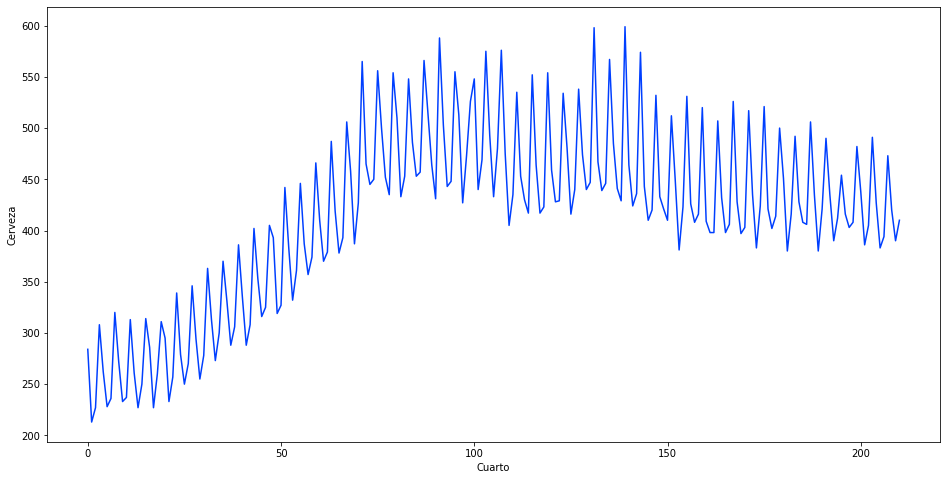

In [104]:
plt.xlabel('Cuarto')
plt.ylabel('Cerveza')
plt.plot(datos)
plt.show()

In [105]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovil = datos.rolling(window = 12).mean()
desviacionMediaMovil = datos.rolling(window = 12).std()

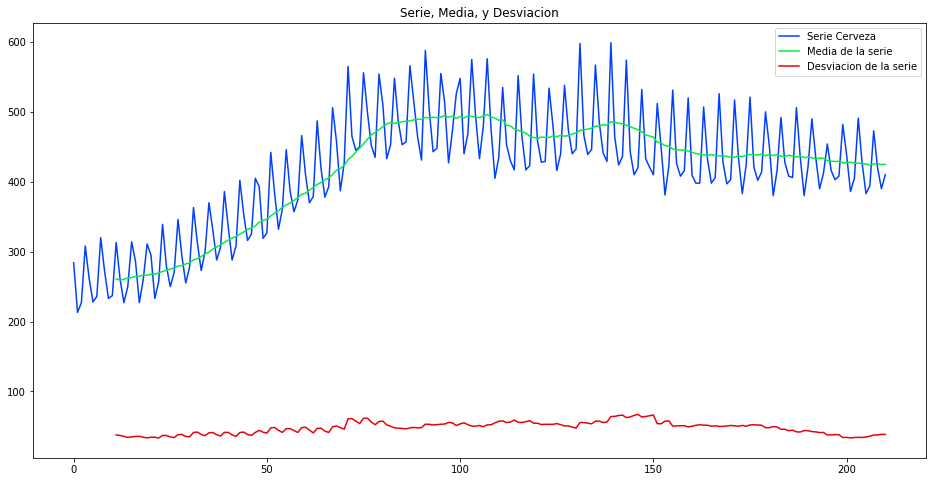

In [106]:
plt.plot(datos, label = 'Serie Cerveza')
plt.plot(mediaMovil, label = 'Media de la serie')
plt.plot(desviacionMediaMovil, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [107]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datos, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

#Para identificar estacionariedad
#Estadistico T < 0
#Valor P < 0.05

Test de Dickey - Fuller: 
Estadistico T               -2.583898
Valor p                      0.096371
Retrasos usados             14.000000
Numero de observaciones    196.000000
Valores criticos (1%)       -3.464161
Valores criticos (5%)       -2.876402
Valores criticos (10%)      -2.574692
dtype: float64


##Transformación

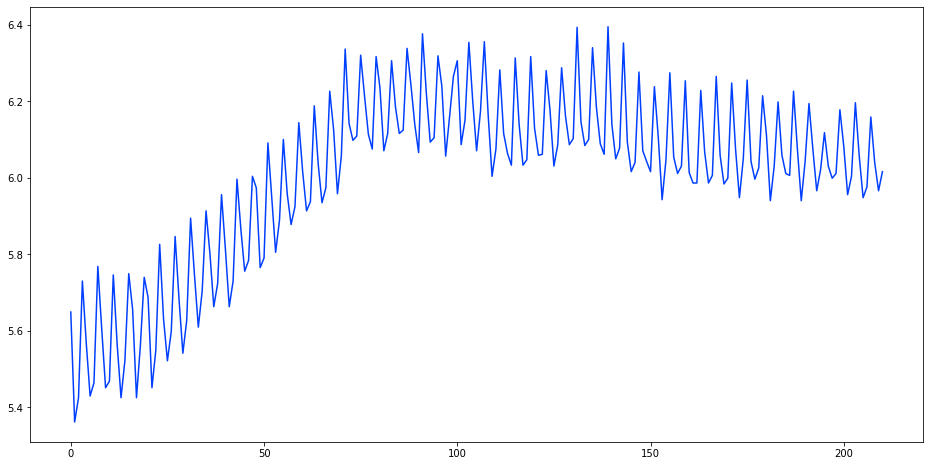

In [108]:
# Aplicar logaritmo
datosLog = np.log(datos)
plt.plot(datosLog)
plt.show()

In [109]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovilLog = datosLog.rolling(window = 12).mean()
desviacionMediaMovilLog = datosLog.rolling(window = 12).std()

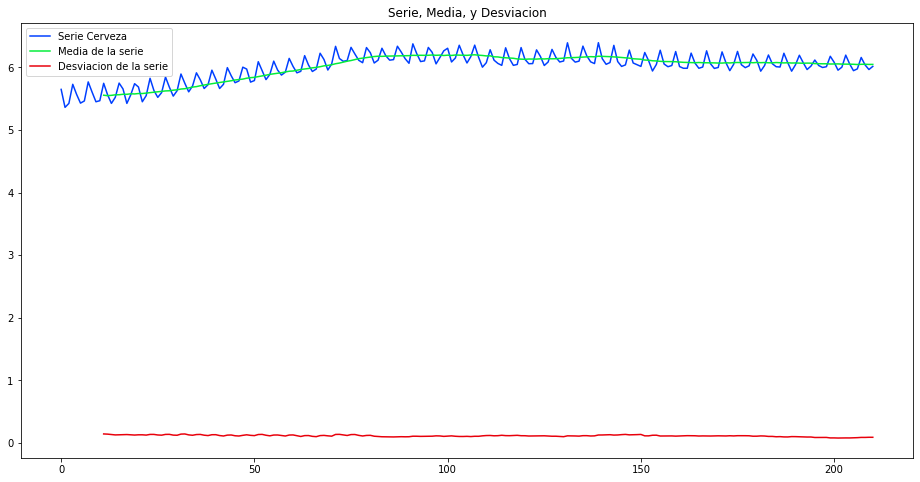

In [110]:
plt.plot(datosLog, label = 'Serie Cerveza')
plt.plot(mediaMovilLog, label = 'Media de la serie')
plt.plot(desviacionMediaMovilLog, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [111]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datosLog, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

Test de Dickey - Fuller: 
Estadistico T               -2.962967
Valor p                      0.038501
Retrasos usados             14.000000
Numero de observaciones    196.000000
Valores criticos (1%)       -3.464161
Valores criticos (5%)       -2.876402
Valores criticos (10%)      -2.574692
dtype: float64


###Descomposición 

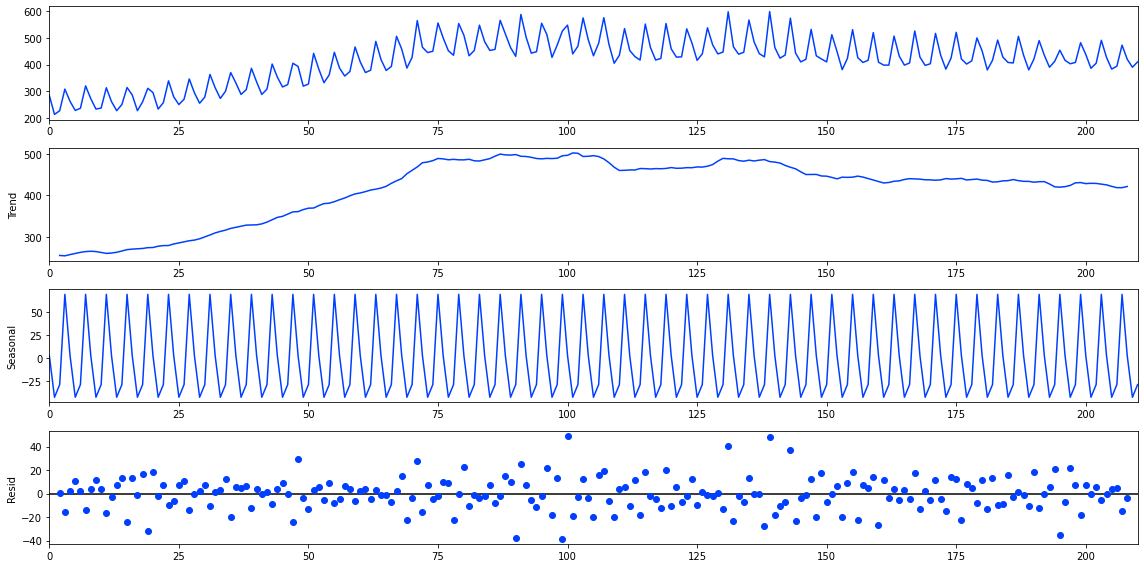

In [112]:
#Descomposicion de la serie de tiempo
descomposicion = seasonal_decompose(datos, period = 4)
grafica = descomposicion.plot()

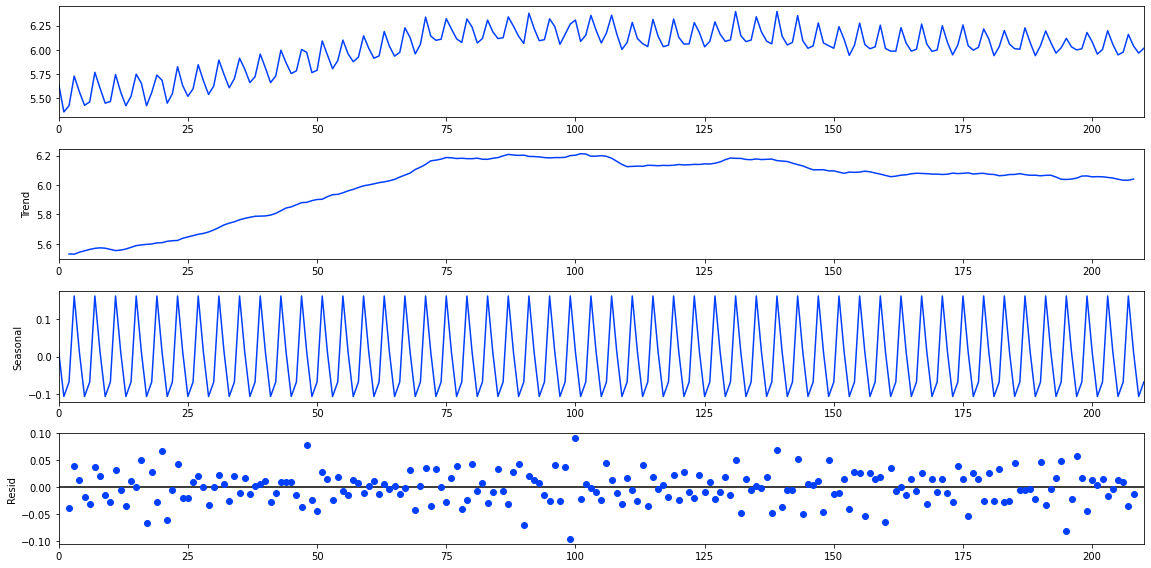

In [113]:
#Descomposicion de la serie de tiempo
descomposicionLog = seasonal_decompose(datosLog, period = 4)
graficaLog = descomposicionLog.plot()

##Modelo Arima

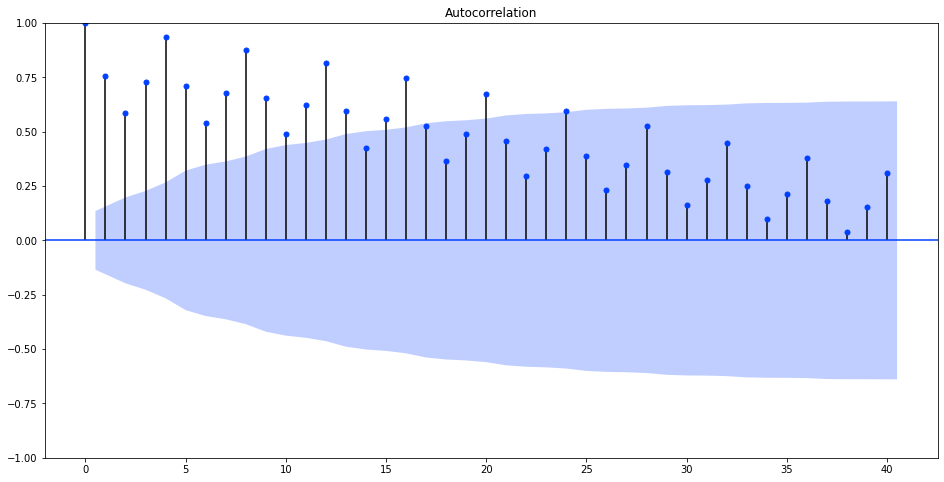

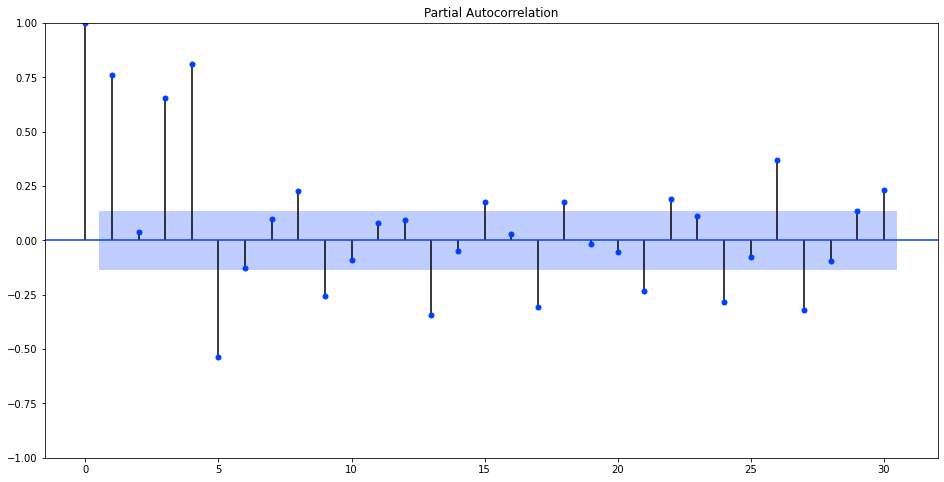

In [114]:
## Modelo Arima
fig = sm.graphics.tsa.plot_acf(datosLog.dropna().values.squeeze(), lags = 40)
fig = sm.graphics.tsa.plot_pacf(datosLog.dropna(), lags = 30)

In [115]:
#Primero Correlación parcial
#Segundo Transformaciones
#Tercero Autocorrelación
modelo = ARIMA(datosLog, order=(2,1,13))
modeloAjustado = modelo.fit()

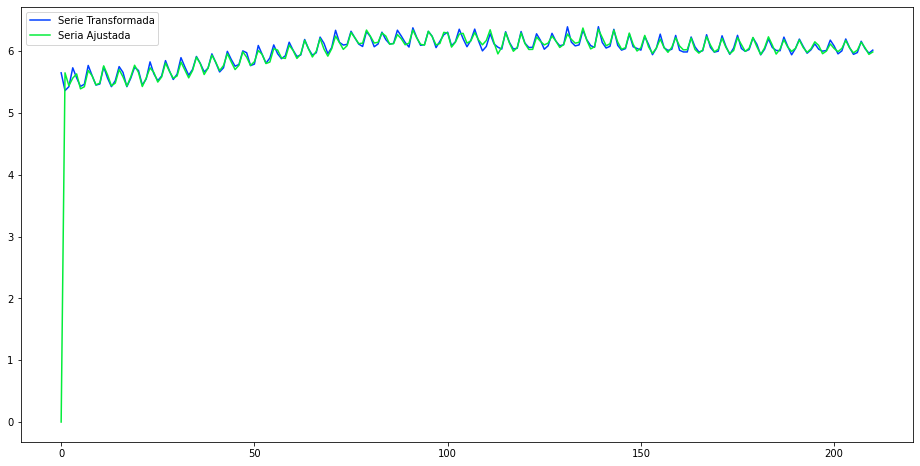

In [116]:
plt.plot(datosLog, label = 'Serie Transformada')
plt.plot(modeloAjustado.fittedvalues, label = 'Seria Ajustada')
plt.legend()
plt.show()

In [117]:
ajustes = pd.DataFrame(modeloAjustado.fittedvalues)
ajustes = ajustes.rename(columns = {0:'Cerveza'})
ajustes

Cerveza
0    0.000000
1    5.648974
2    5.440700
3    5.563270
4    5.631875
..        ...
206  6.015400
207  6.144046
208  6.053108
209  5.946817
210  5.986959

[211 rows x 1 columns]

In [118]:
ajustes= ajustes.drop(0, axis=0)

In [119]:
predicciones = np.exp(ajustes)
predicciones = predicciones.dropna()
predicciones

Cerveza
1    283.999994
2    230.603539
3    260.673819
4    279.185027
5    219.143094
..          ...
206  409.689835
207  465.934940
208  425.433191
209  382.533814
210  398.201653

[210 rows x 1 columns]

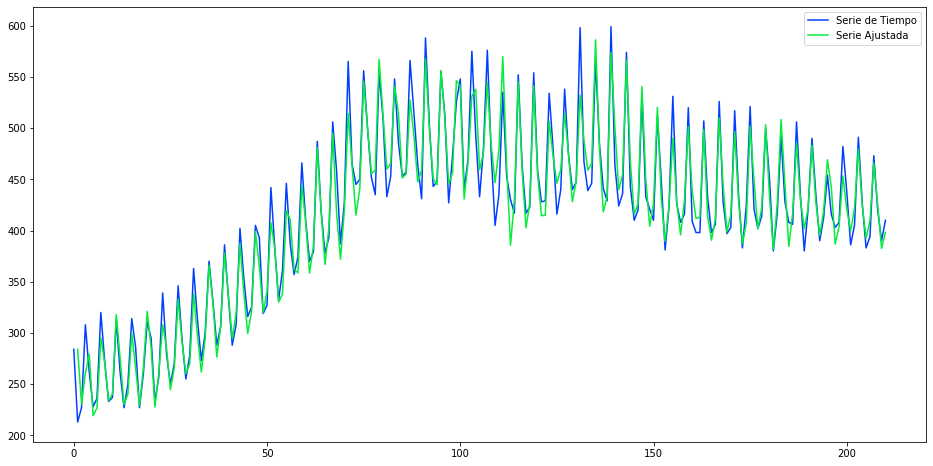

In [120]:
plt.plot(datos, label='Serie de Tiempo')
plt.plot(predicciones, label='Serie Ajustada')
plt.legend()
plt.show()

In [121]:
m = 4
alfa = 1/(2*m)

##Suavización Exponencial

In [122]:
datosSES = SimpleExpSmoothing(datos).fit(smoothing_level = alfa, optimized = False).fittedvalues
datos.head()

0    284.0
1    213.0
2    227.0
3    308.0
4    262.0
dtype: float64

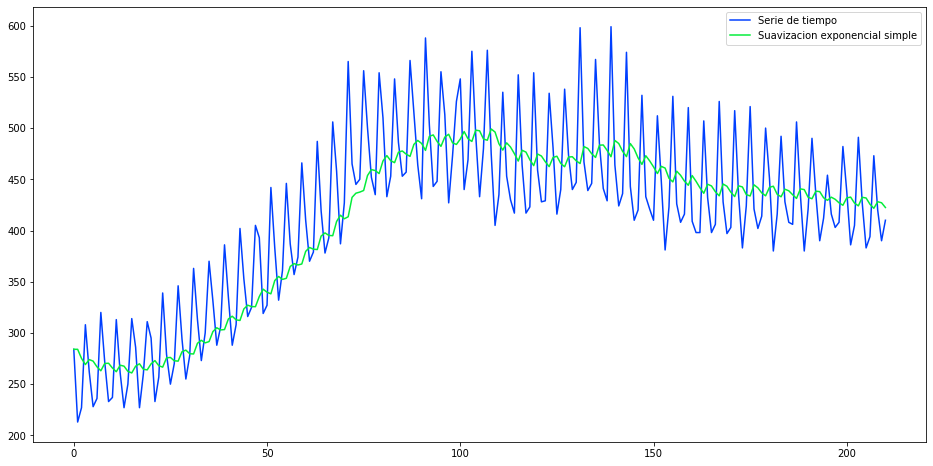

In [123]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSES, label = 'Suavizacion exponencial simple')
plt.legend()
plt.show()

In [124]:
## Suavizacion exponencial holt-winters
datosSEHW1 = ExponentialSmoothing(datos, trend = 'add').fit().fittedvalues
datos.head()

0    284.0
1    213.0
2    227.0
3    308.0
4    262.0
dtype: float64

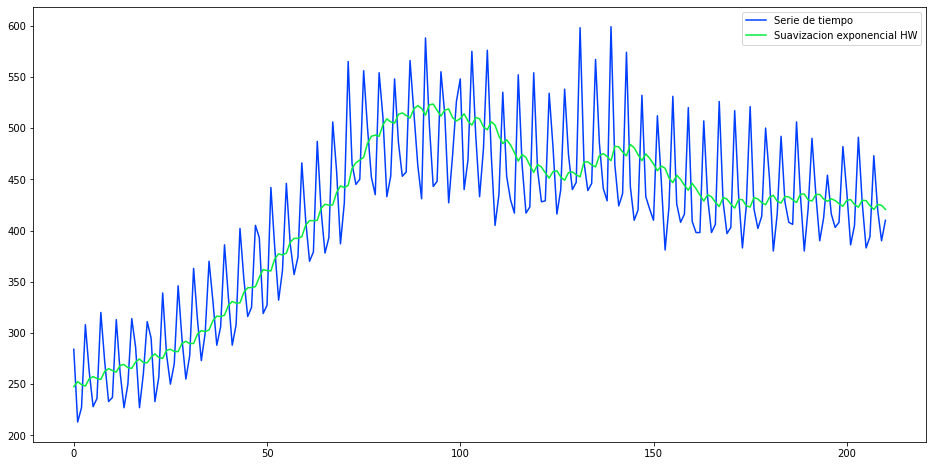

In [125]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW1, label = 'Suavizacion exponencial HW')
plt.legend()
plt.show()

In [126]:
datosSEHW2 = ExponentialSmoothing(datos, trend = 'mul').fit().fittedvalues
datos.head()

0    284.0
1    213.0
2    227.0
3    308.0
4    262.0
dtype: float64

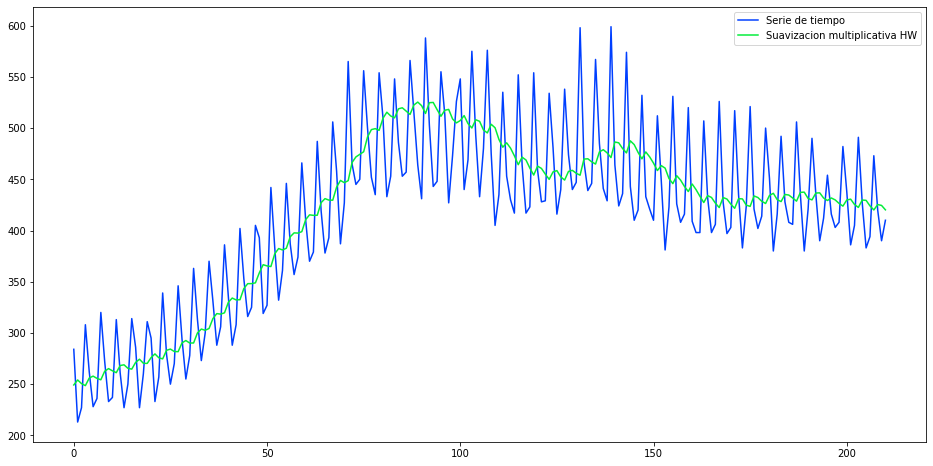

In [127]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW2, label = 'Suavizacion multiplicativa HW')
plt.legend()
plt.show()

In [128]:
datosSEHW3 = ExponentialSmoothing(datos, trend = 'mul', seasonal = 'add', seasonal_periods = 4).fit().fittedvalues
datos.head()

0    284.0
1    213.0
2    227.0
3    308.0
4    262.0
dtype: float64

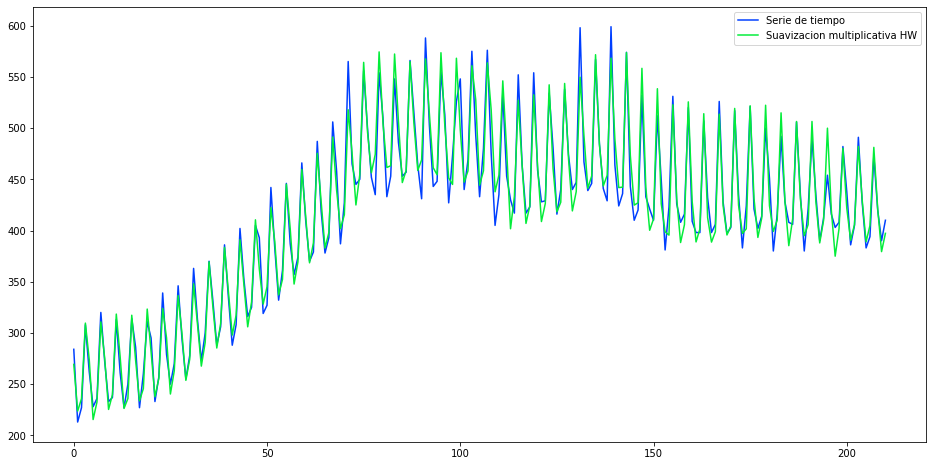

In [129]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW3, label = 'Suavizacion multiplicativa HW')
plt.legend()
plt.show()

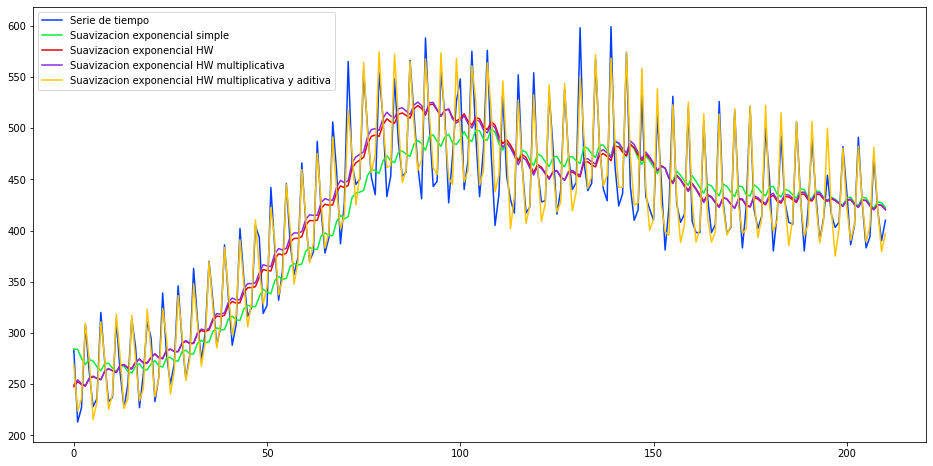

In [130]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSES, label = 'Suavizacion exponencial simple')
plt.plot(datosSEHW1, label = 'Suavizacion exponencial HW')
plt.plot(datosSEHW2, label = 'Suavizacion exponencial HW multiplicativa')
plt.plot(datosSEHW3, label = 'Suavizacion exponencial HW multiplicativa y aditiva')

plt.legend()
plt.show()

In [131]:
datosAjuste = datos[:180]
datosValidacion = datos[180:]

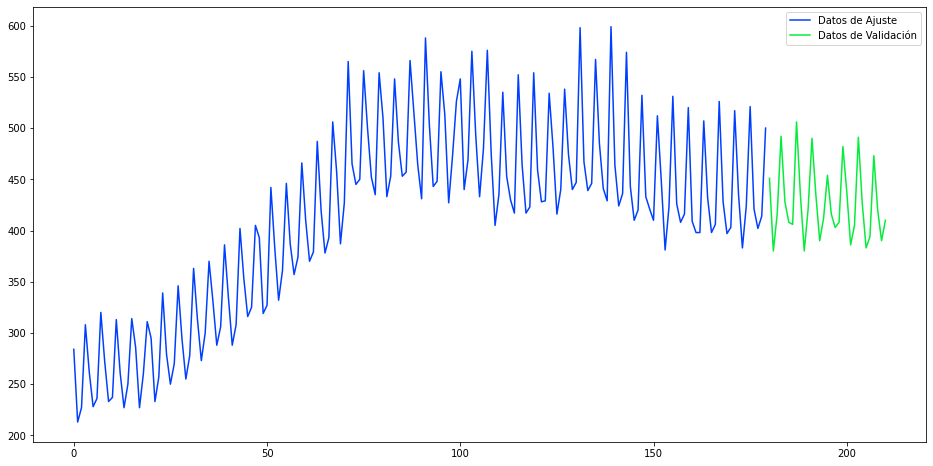

In [132]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.legend()
plt.show()

In [133]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add',seasonal_periods=4).fit()
predicciones= modeloAjustado.forecast(56)

In [134]:
predicciones

180    424.355320
181    392.385951
182    406.336850
183    515.932237
184    422.586757
185    390.617703
186    404.568917
187    514.164618
188    420.819453
189    388.850713
190    402.802241
191    512.398257
192    419.053406
193    387.084980
194    401.036823
195    510.633153
196    417.288616
197    385.320504
198    399.272661
199    508.869304
200    415.525081
201    383.557284
202    397.509754
203    507.106711
204    413.762802
205    381.795318
206    395.748102
207    505.345372
208    412.001777
209    380.034606
210    393.987703
211    503.585287
212    410.242004
213    378.275146
214    392.228557
215    501.826454
216    408.483484
217    376.516939
218    390.470662
219    500.068872
220    406.726215
221    374.759983
222    388.714019
223    498.312541
224    404.970197
225    373.004277
226    386.958625
227    496.557460
228    403.215428
229    371.249821
230    385.204481
231    494.803628
232    401.461908
233    369.496612
234    383.451585
235    493

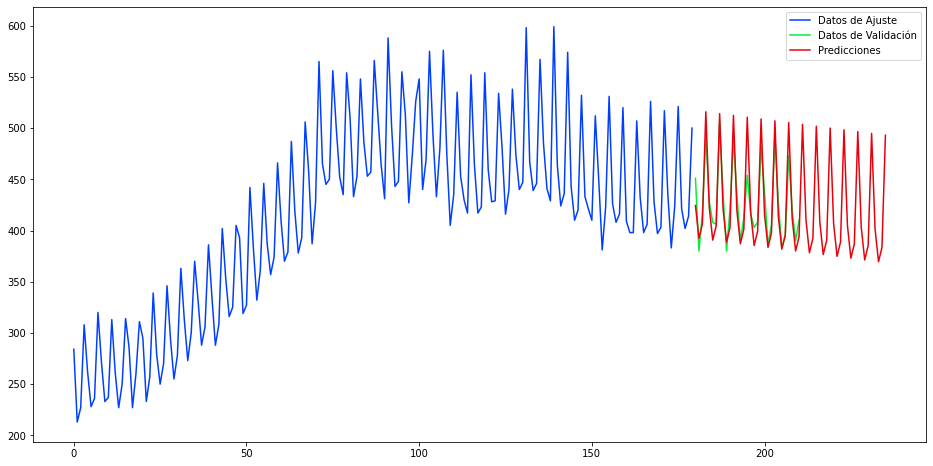

In [135]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

##Auto ARIMA

In [136]:
modeloAuto = pm.auto_arima(datos, seasonal=True, stationary=False, start_q=1, start_p=1, d=1)

In [137]:
modeloAuto.params()

ar.L1      -1.841827
ar.L2      -2.139171
ar.L3      -2.134104
ar.L4      -1.135671
ar.L5      -0.297406
ma.L1       0.919028
ma.L2       0.756571
ma.L3       0.722267
sigma2    254.203454
dtype: float64

In [138]:
modeloAuto.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (5, 1, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [139]:
predAuto = modeloAuto.predict(56)

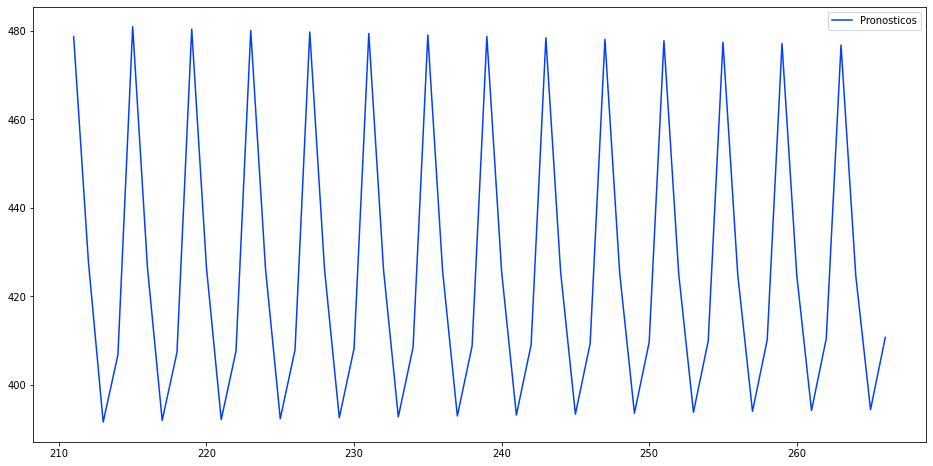

In [140]:
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

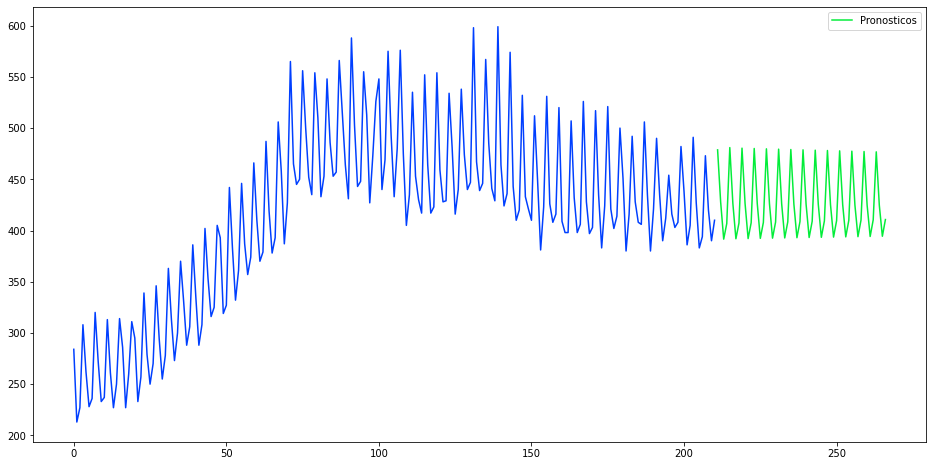

In [141]:
plt.figure(figsize= (16,8))
plt.plot(datos)
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

#Punto 2

##Exploración de Datos

In [142]:
###Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm

import warnings


In [143]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('seaborn-bright')

In [144]:
datos = pm.datasets.load_austres(as_series=True)
print(datos.shape)
datos.head()

(89,)


0    13067.3
1    13130.5
2    13198.4
3    13254.2
4    13303.7
dtype: float64

In [145]:
datos = datos.dropna()

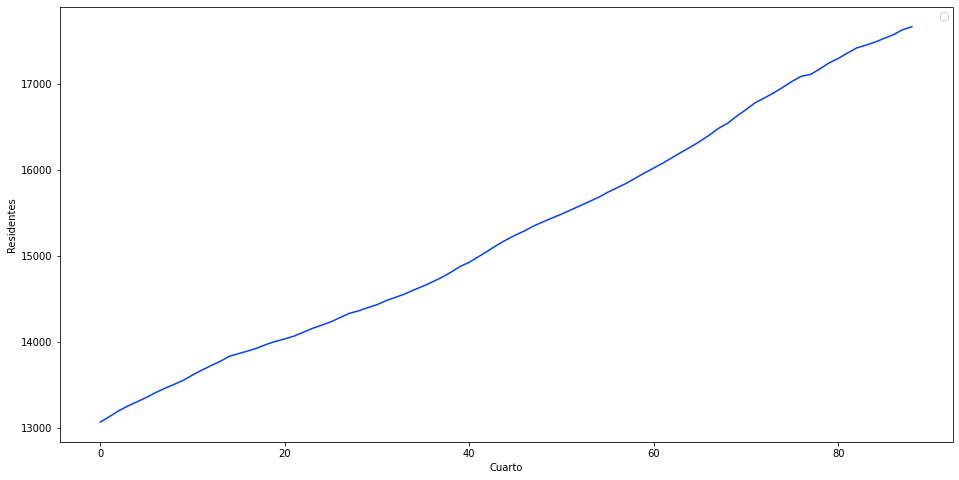

In [158]:
plt.xlabel('Cuarto')
plt.ylabel('Residentes')
plt.legend()
plt.plot(datos)
plt.show()

In [147]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovil = datos.rolling(window = 12).mean()
desviacionMediaMovil = datos.rolling(window = 12).std()

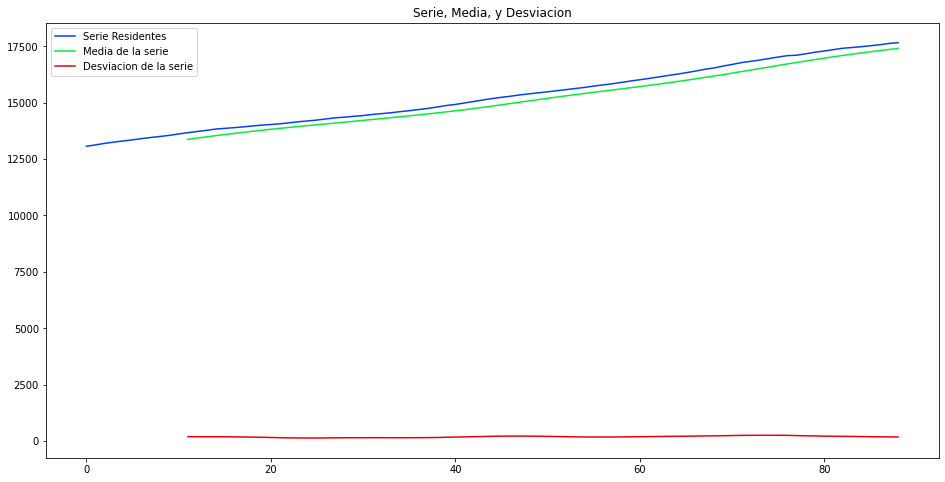

In [148]:
plt.plot(datos, label = 'Serie Residentes')
plt.plot(mediaMovil, label = 'Media de la serie')
plt.plot(desviacionMediaMovil, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [149]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datos, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

#Para identificar estacionalidad
#Estadistico T < 0
#Valor P < 0.05

Test de Dickey - Fuller: 
Estadistico T               0.517268
Valor p                     0.985389
Retrasos usados             4.000000
Numero de observaciones    84.000000
Valores criticos (1%)      -3.510712
Valores criticos (5%)      -2.896616
Valores criticos (10%)     -2.585482
dtype: float64


##Transformación

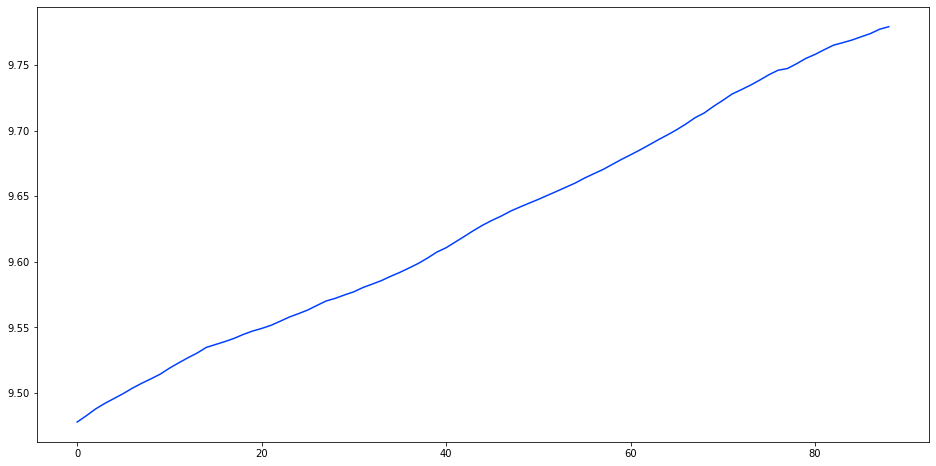

In [150]:
# Aplicar logaritmo
datosLog = np.log(datos)
plt.plot(datosLog)
plt.show()

In [151]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovilLog = datosLog.rolling(window = 12).mean()
desviacionMediaMovilLog = datosLog.rolling(window = 12).std()

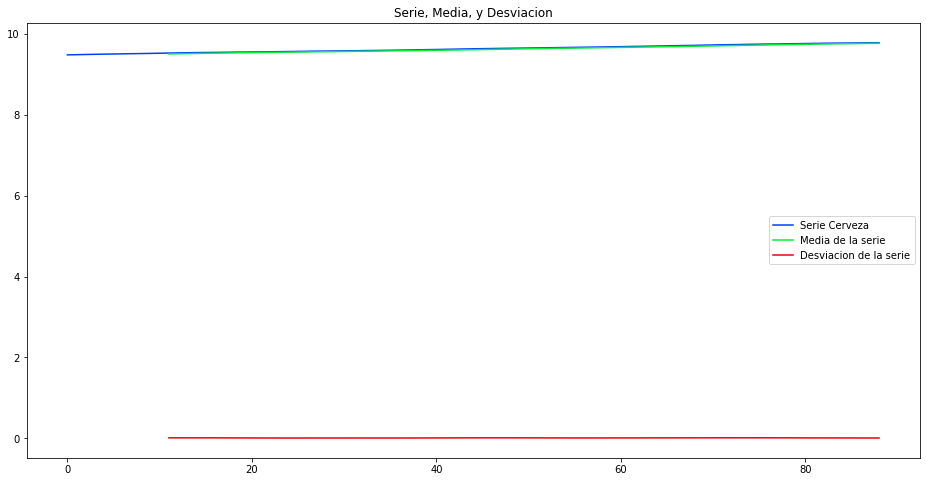

In [152]:
plt.plot(datosLog, label = 'Serie Residentes')
plt.plot(mediaMovilLog, label = 'Media de la serie')
plt.plot(desviacionMediaMovilLog, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [153]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datosLog, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

Test de Dickey - Fuller: 
Estadistico T              -0.005479
Valor p                     0.958077
Retrasos usados             6.000000
Numero de observaciones    82.000000
Valores criticos (1%)      -3.512738
Valores criticos (5%)      -2.897490
Valores criticos (10%)     -2.585949
dtype: float64


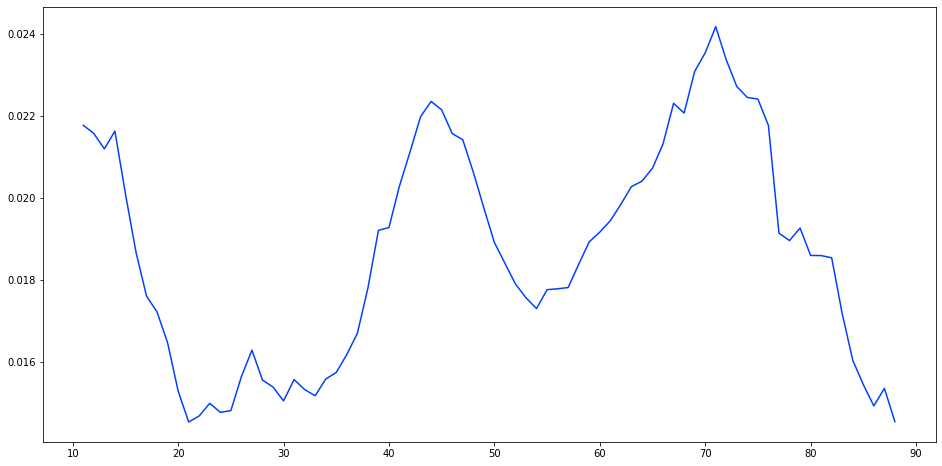

In [154]:
datosDif = datosLog - mediaMovilLog
plt.plot(datosDif)
plt.show()

In [156]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovilDif = datosDif.rolling(window = 12).mean()
desviacionMediaMovilDif = datosDif.rolling(window = 12).std()

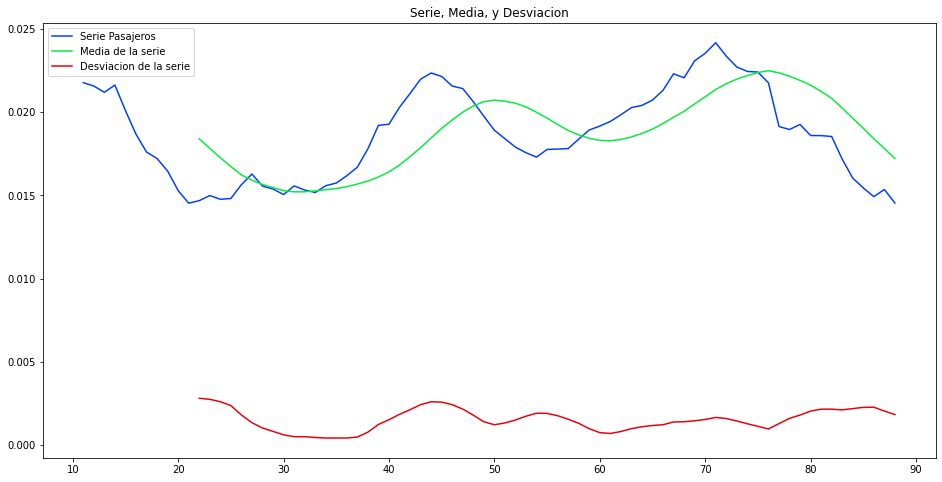

In [157]:
plt.plot(datosDif, label = 'Serie Residentes')
plt.plot(mediaMovilDif, label = 'Media de la serie')
plt.plot(desviacionMediaMovilDif, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [163]:
datosDif = datosDif.dropna()

In [164]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datosDif, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

Test de Dickey - Fuller: 
Estadistico T              -3.077818
Valor p                     0.028239
Retrasos usados             4.000000
Numero de observaciones    73.000000
Valores criticos (1%)      -3.523284
Valores criticos (5%)      -2.902031
Valores criticos (10%)     -2.588371
dtype: float64


###Descomposición 

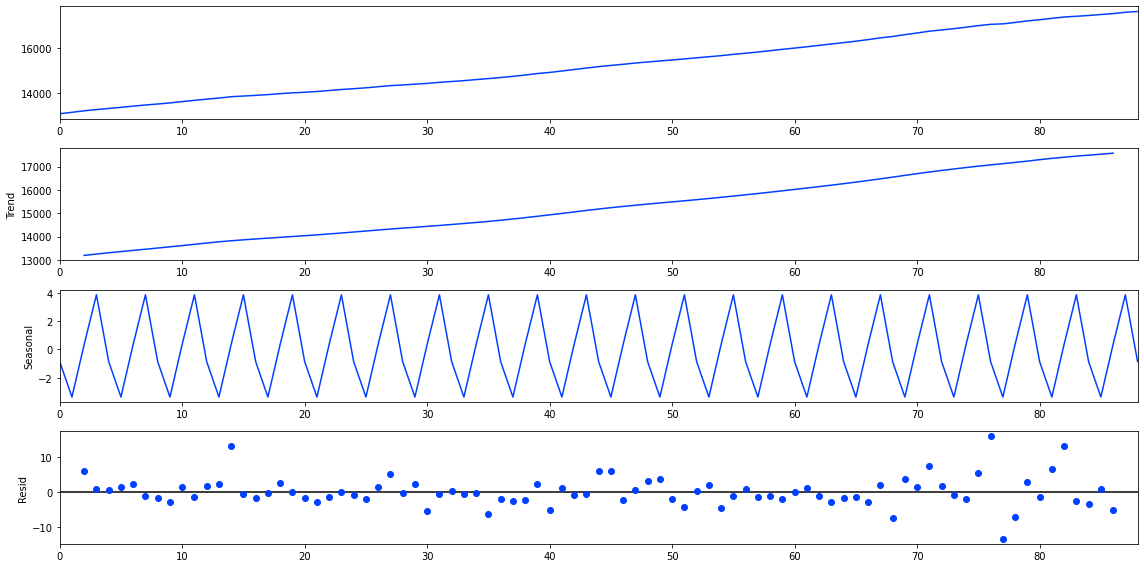

In [160]:
#Descomposicion de la serie de tiempo
descomposicion = seasonal_decompose(datos, period = 4)
grafica = descomposicion.plot()

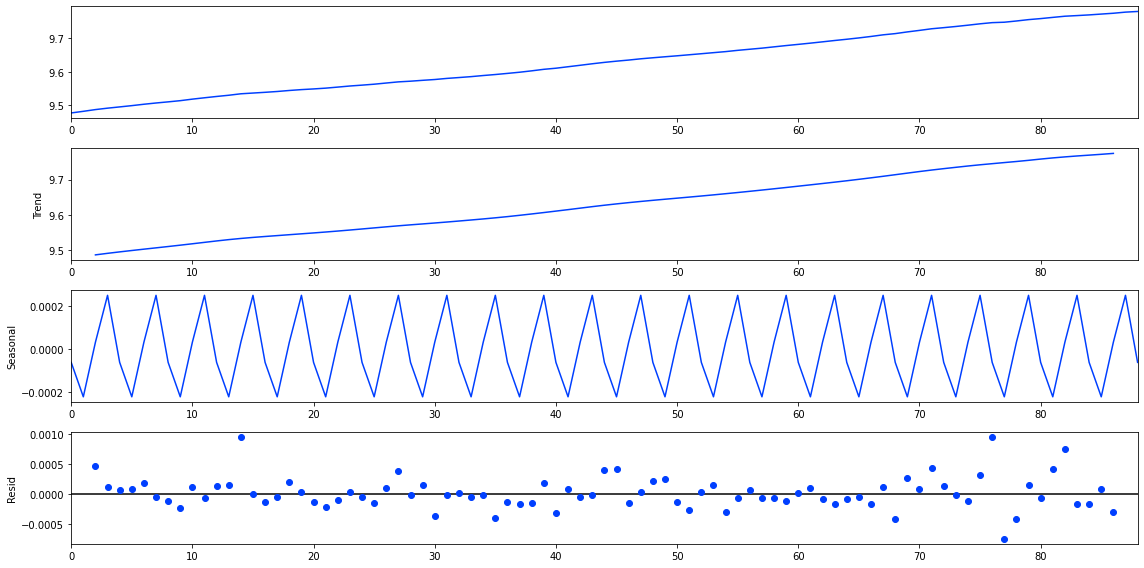

In [165]:
#Descomposicion de la serie de tiempo
descomposicionLog = seasonal_decompose(datosLog, period = 4)
graficaLog = descomposicionLog.plot()

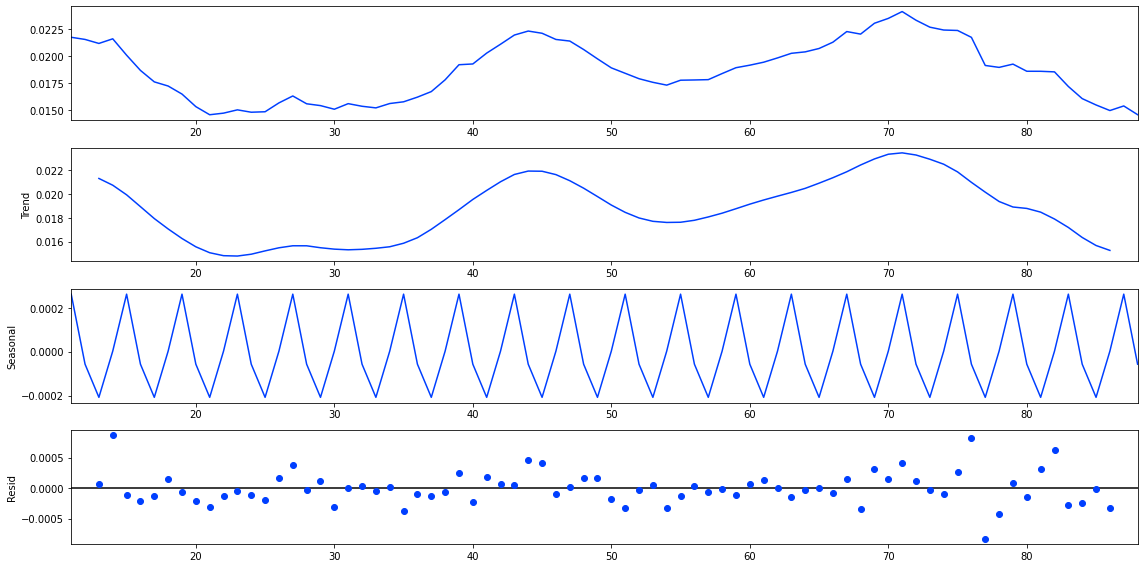

In [166]:
#Descomposicion de la serie de tiempo
descomposicionDif = seasonal_decompose(datosDif, period = 4)
graficaDif = descomposicionDif.plot()

##Modelo Arima

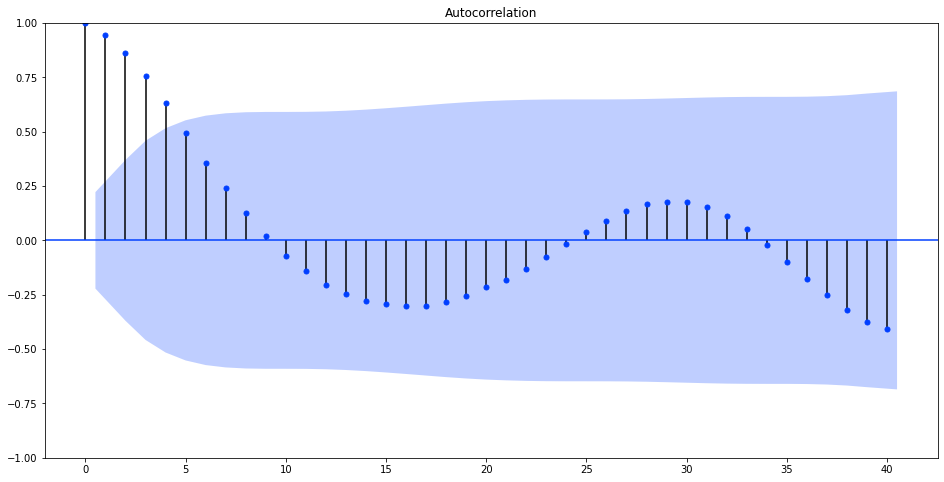

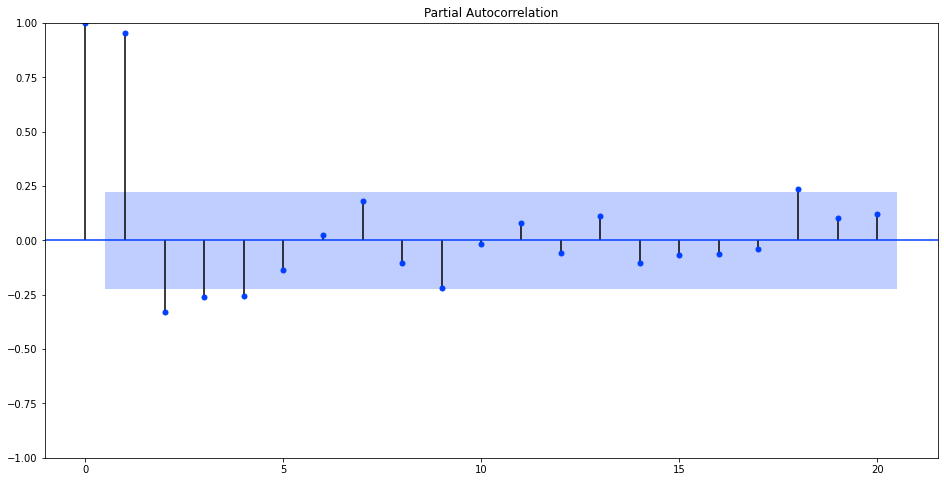

In [169]:
## Modelo Arima
fig = sm.graphics.tsa.plot_acf(datosDif.values.squeeze(), lags = 40)
fig = sm.graphics.tsa.plot_pacf(datosDif, lags = 20)

In [170]:
#Primero Correlación parcial
#Segundo Transformaciones
#Tercero Autocorrelación
modelo = ARIMA(datosDif, order=(4,2,4))
modeloAjustado = modelo.fit()

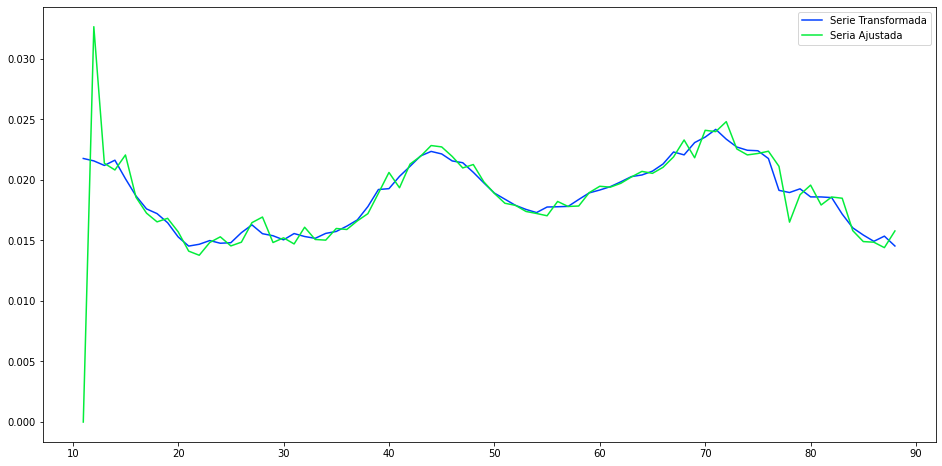

In [171]:
plt.plot(datosDif, label = 'Serie Transformada')
plt.plot(modeloAjustado.fittedvalues, label = 'Seria Ajustada')
plt.legend()
plt.show()

In [172]:
ajustes = pd.DataFrame(modeloAjustado.fittedvalues)
ajustes = ajustes.rename(columns = {0:'Residentes'})
ajustes

Residentes
11    0.000000
12    0.032649
13    0.021365
14    0.020816
15    0.022055
..         ...
84    0.015806
85    0.014903
86    0.014851
87    0.014402
88    0.015780

[78 rows x 1 columns]

In [173]:
ajustes= ajustes.drop(11, axis=0)

In [177]:
predicciones = np.exp(ajustes['Residentes']+mediaMovilLog)
predicciones = predicciones.dropna()
predicciones

12    13875.541821
13    13774.501034
14    13820.837051
15    13889.825765
16    13891.498705
          ...     
84    17478.566828
85    17516.525537
86    17567.428081
87    17610.371227
88    17683.457074
Length: 77, dtype: float64

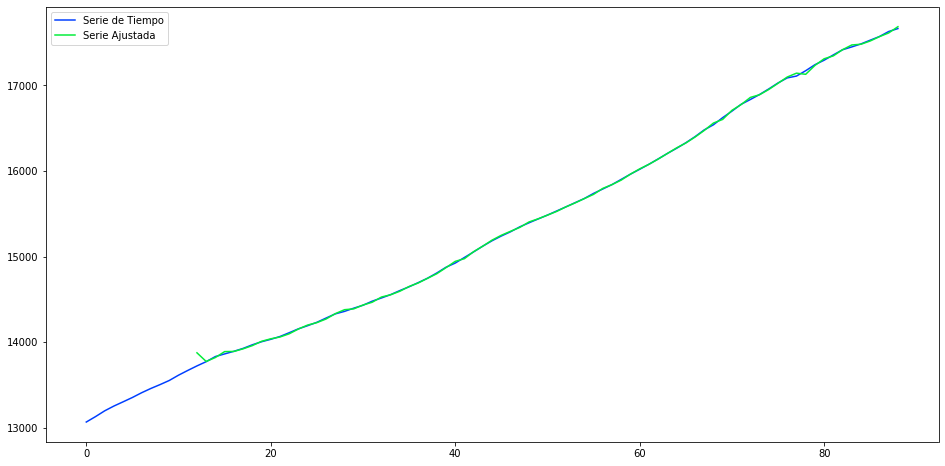

In [178]:
plt.plot(datos, label='Serie de Tiempo')
plt.plot(predicciones, label='Serie Ajustada')
plt.legend()
plt.show()

In [179]:
m = 4
alfa = 1/(2*m)

##Suavización Exponencial

In [180]:
datosSES = SimpleExpSmoothing(datos).fit(smoothing_level = alfa, optimized = False).fittedvalues
datos.head()

0    13067.3
1    13130.5
2    13198.4
3    13254.2
4    13303.7
dtype: float64

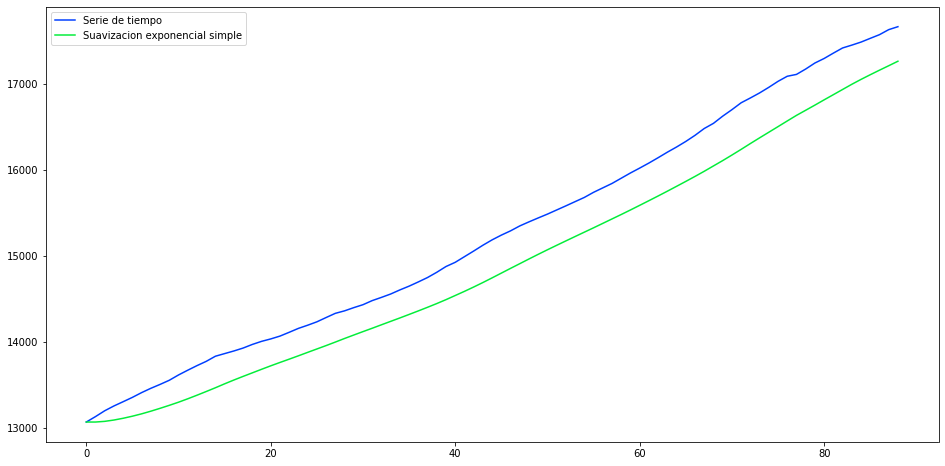

In [181]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSES, label = 'Suavizacion exponencial simple')
plt.legend()
plt.show()

In [182]:
## Suavizacion exponencial holt-winters
datosSEHW1 = ExponentialSmoothing(datos, trend = 'add').fit().fittedvalues
datos.head()

0    13067.3
1    13130.5
2    13198.4
3    13254.2
4    13303.7
dtype: float64

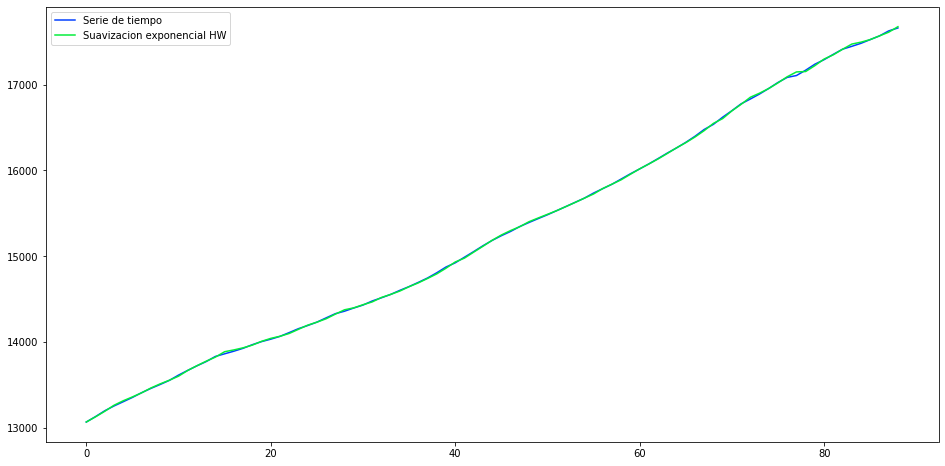

In [183]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW1, label = 'Suavizacion exponencial HW')
plt.legend()
plt.show()

In [184]:
datosSEHW2 = ExponentialSmoothing(datos, trend = 'mul').fit().fittedvalues
datos.head()

0    13067.3
1    13130.5
2    13198.4
3    13254.2
4    13303.7
dtype: float64

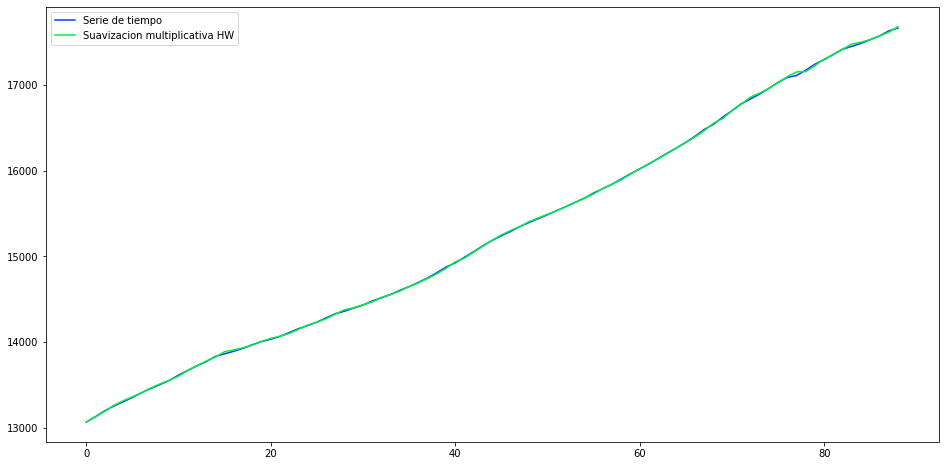

In [185]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW2, label = 'Suavizacion multiplicativa HW')
plt.legend()
plt.show()

In [186]:
datosSEHW3 = ExponentialSmoothing(datos, trend = 'mul', seasonal = 'add', seasonal_periods = 4).fit().fittedvalues
datos.head()

0    13067.3
1    13130.5
2    13198.4
3    13254.2
4    13303.7
dtype: float64

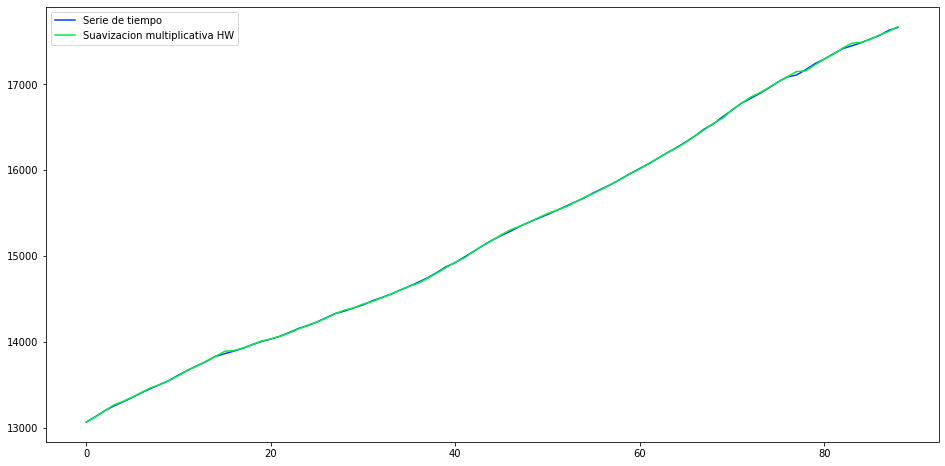

In [187]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW3, label = 'Suavizacion multiplicativa HW')
plt.legend()
plt.show()

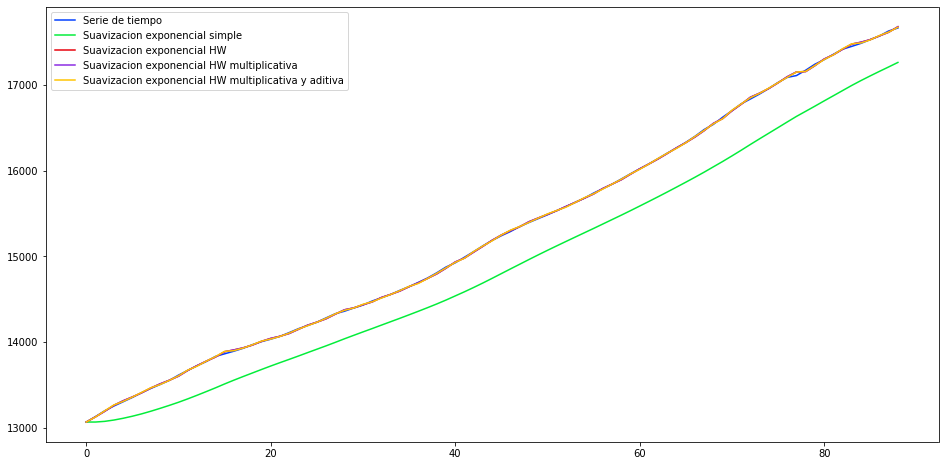

In [188]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSES, label = 'Suavizacion exponencial simple')
plt.plot(datosSEHW1, label = 'Suavizacion exponencial HW')
plt.plot(datosSEHW2, label = 'Suavizacion exponencial HW multiplicativa')
plt.plot(datosSEHW3, label = 'Suavizacion exponencial HW multiplicativa y aditiva')

plt.legend()
plt.show()

In [191]:
datosAjuste = datos[:80]
datosValidacion = datos[80:]

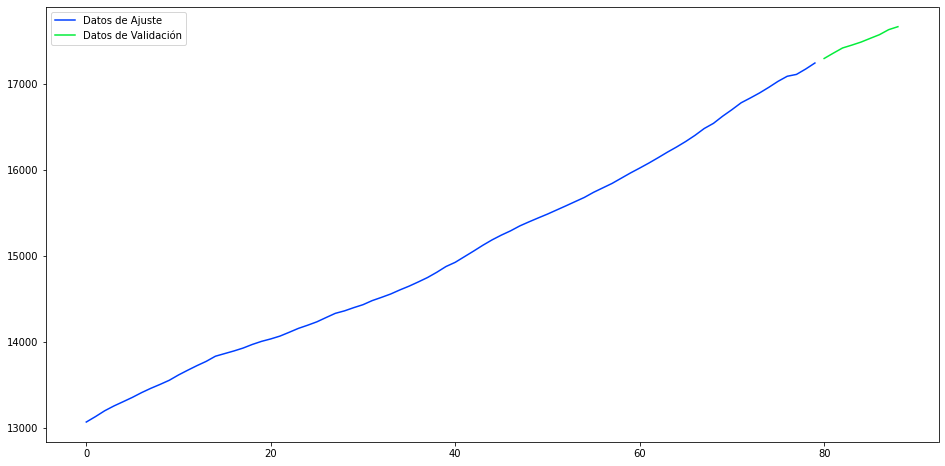

In [192]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.legend()
plt.show()

In [193]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add',seasonal_periods=4).fit()
predicciones= modeloAjustado.forecast(56)

In [194]:
predicciones

80     17293.571614
81     17354.742619
82     17426.284027
83     17491.800770
84     17547.128992
85     17609.224156
86     17681.693091
87     17748.140742
88     17804.403265
89     17867.436135
90     17940.846194
91     18008.238399
92     18065.448920
93     18129.433241
94     18203.798221
95     18272.148826
96     18330.321240
97     18395.270961
98     18470.604858
99     18539.927913
100    18599.076321
101    18665.005593
102    18741.322612
103    18811.632372
104    18871.771080
105    18938.694263
106    19016.008815
107    19087.319743
108    19148.463270
109    19216.394933
110    19294.721641
111    19367.048414
112    19429.211488
113    19498.166414
114    19577.520115
115    19650.877624
116    19714.075191
117    19784.068381
118    19864.464129
119    19938.867484
120    20003.114709
121    20074.161382
122    20155.614454
123    20231.078985
124    20296.391254
125    20368.506854
126    20451.032748
127    20527.574012
128    20593.966938
129    20667.167133


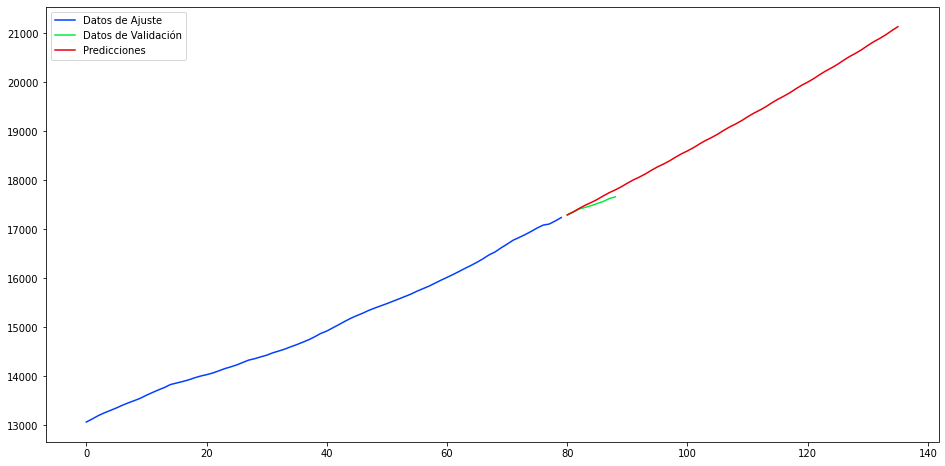

In [195]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

##Auto ARIMA

In [196]:
modeloAuto = pm.auto_arima(datos, seasonal=True, stationary=False, start_q=1, start_p=1, d=1)

In [197]:
modeloAuto.params()

intercept     5.907053
ar.L1         0.886446
ma.L1        -0.512464
sigma2       96.100991
dtype: float64

In [198]:
modeloAuto.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [199]:
predAuto = modeloAuto.predict(56)

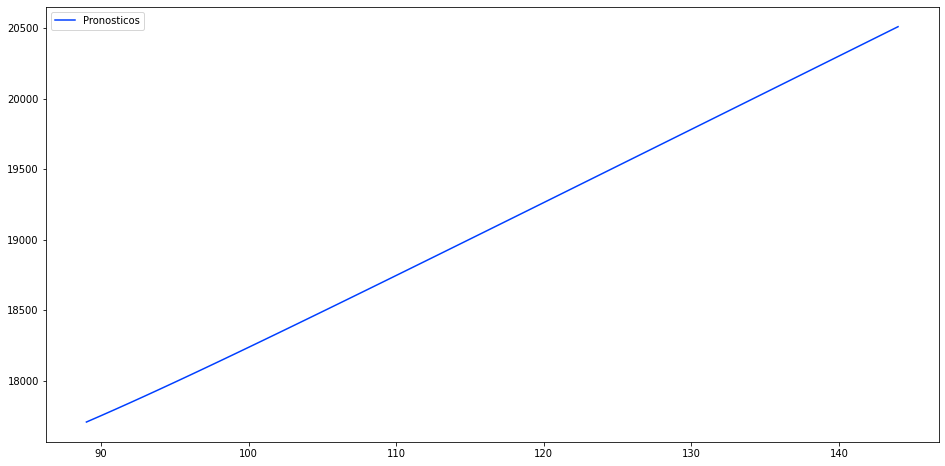

In [200]:
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

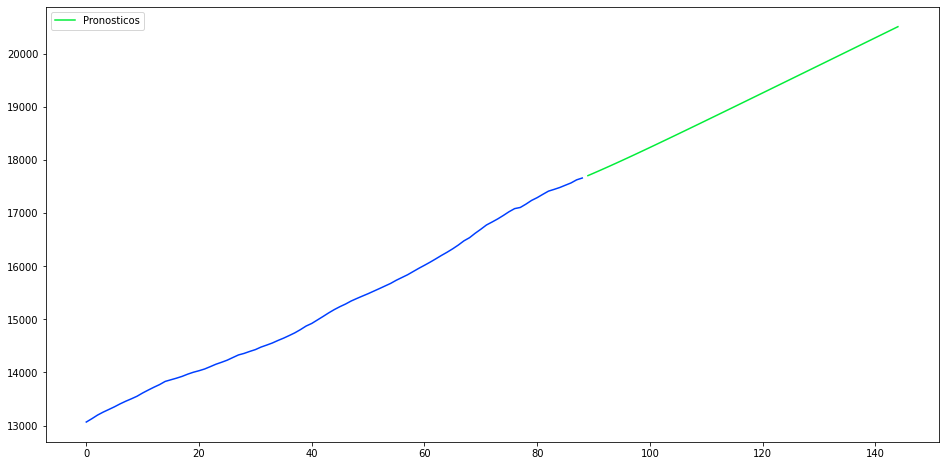

In [201]:
plt.figure(figsize= (16,8))
plt.plot(datos)
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

#Punto 3

##Exploración de Datos

In [203]:
###Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm

import warnings


In [204]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('seaborn-bright')

In [205]:
datos = pm.datasets.load_gasoline(as_series=True)
print(datos.shape)
datos.head()

(745,)


0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

In [206]:
datos = datos.dropna()

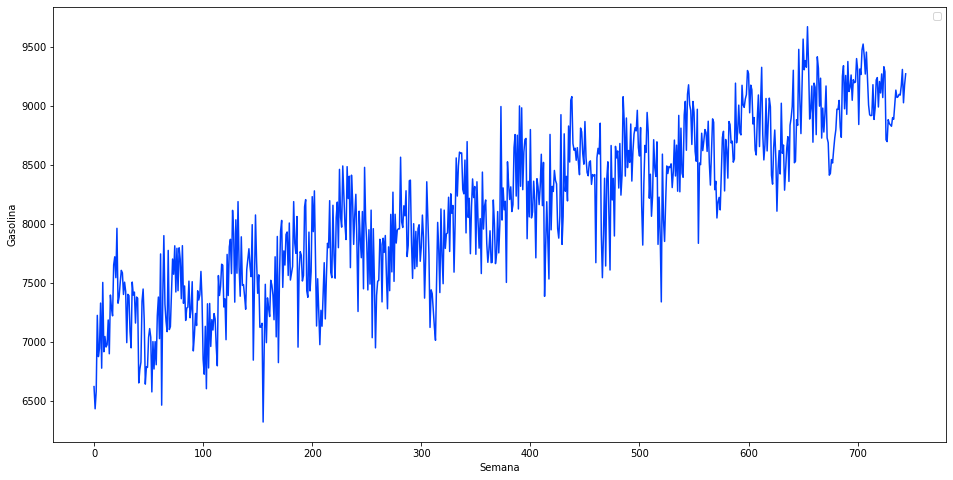

In [207]:
plt.xlabel('Semana')
plt.ylabel('Gasolina')
plt.legend()
plt.plot(datos)
plt.show()

In [208]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovil = datos.rolling(window = 12).mean()
desviacionMediaMovil = datos.rolling(window = 12).std()

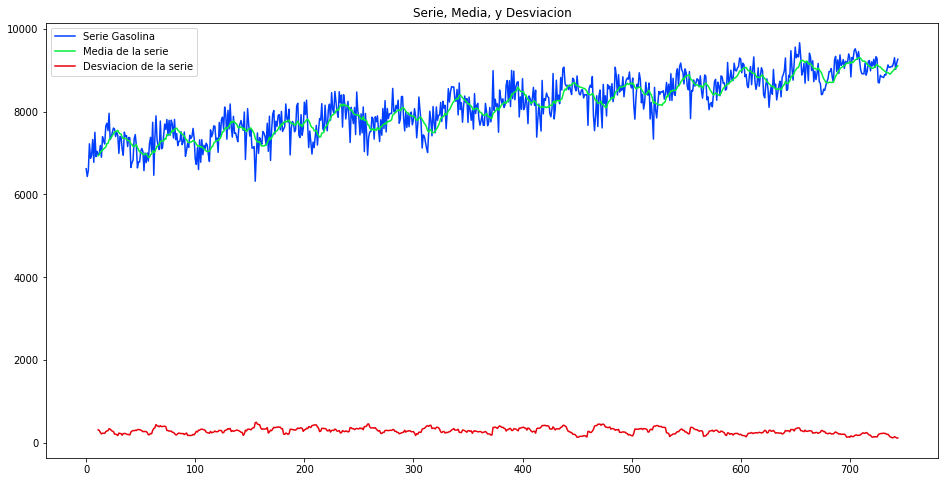

In [209]:
plt.plot(datos, label = 'Serie Gasolina')
plt.plot(mediaMovil, label = 'Media de la serie')
plt.plot(desviacionMediaMovil, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [210]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datos, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

#Para identificar estacionalidad
#Estadistico T < 0
#Valor P < 0.05

Test de Dickey - Fuller: 
Estadistico T               -1.866125
Valor p                      0.348161
Retrasos usados              8.000000
Numero de observaciones    736.000000
Valores criticos (1%)       -3.439266
Valores criticos (5%)       -2.865475
Valores criticos (10%)      -2.568865
dtype: float64


##Transformación

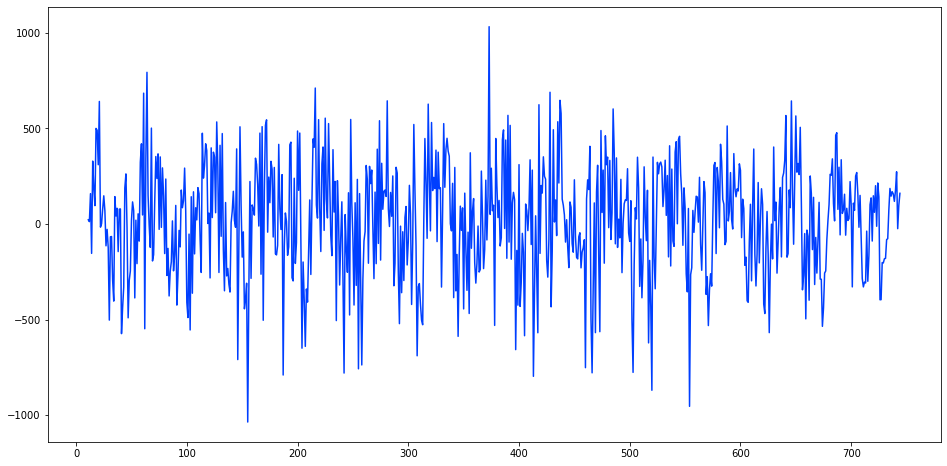

In [211]:
datosDif = datos - mediaMovil
plt.plot(datosDif)
plt.show()

In [212]:
## Identificación de la estacionariedad por mecanismos graficos
mediaMovilDif = datosDif.rolling(window = 12).mean()
desviacionMediaMovilDif = datosDif.rolling(window = 12).std()

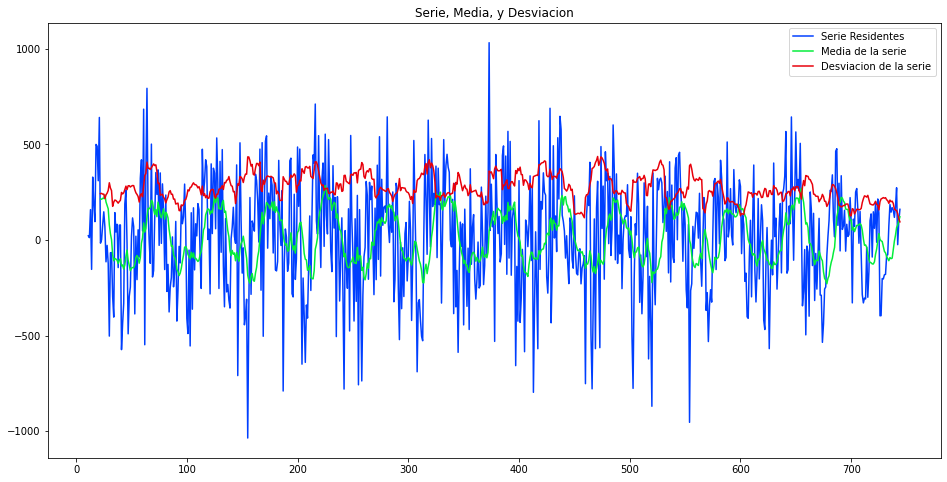

In [213]:
plt.plot(datosDif, label = 'Serie Residentes')
plt.plot(mediaMovilDif, label = 'Media de la serie')
plt.plot(desviacionMediaMovilDif, label = 'Desviacion de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media, y Desviacion')
plt.show()

In [214]:
datosDif = datosDif.dropna()

In [215]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datosDif, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Estadistico T', 'Valor p', 'Retrasos usados', 'Numero de observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores criticos (%s)'%key] = value

print(dfoutput)

Test de Dickey - Fuller: 
Estadistico T             -9.671592e+00
Valor p                    1.272615e-16
Retrasos usados            4.000000e+00
Numero de observaciones    7.290000e+02
Valores criticos (1%)     -3.439352e+00
Valores criticos (5%)     -2.865513e+00
Valores criticos (10%)    -2.568886e+00
dtype: float64


###Descomposición 

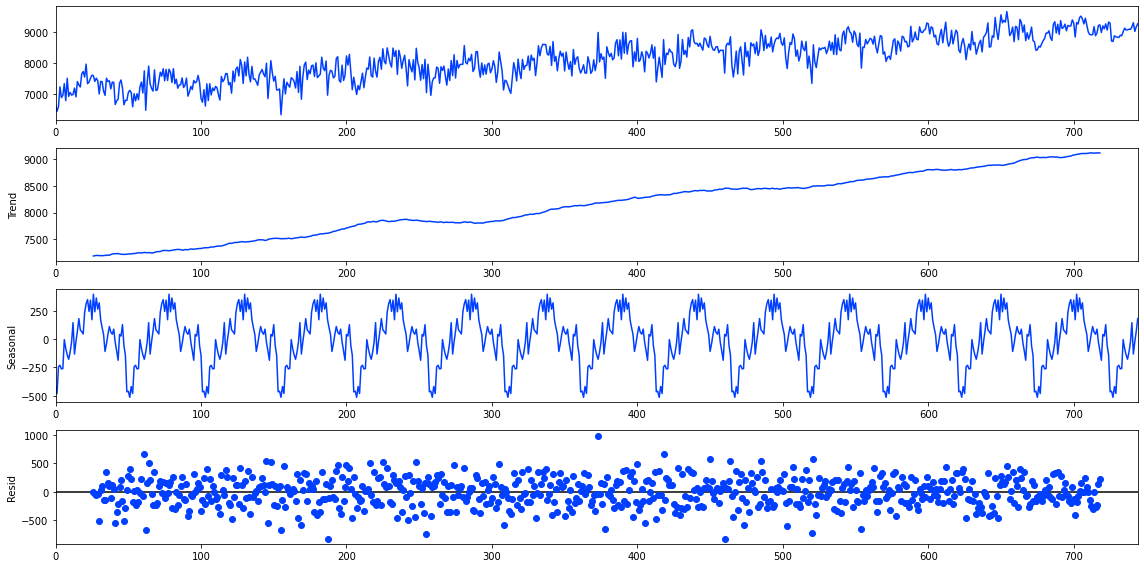

In [216]:
#Descomposicion de la serie de tiempo
descomposicion = seasonal_decompose(datos, period = 52)
grafica = descomposicion.plot()

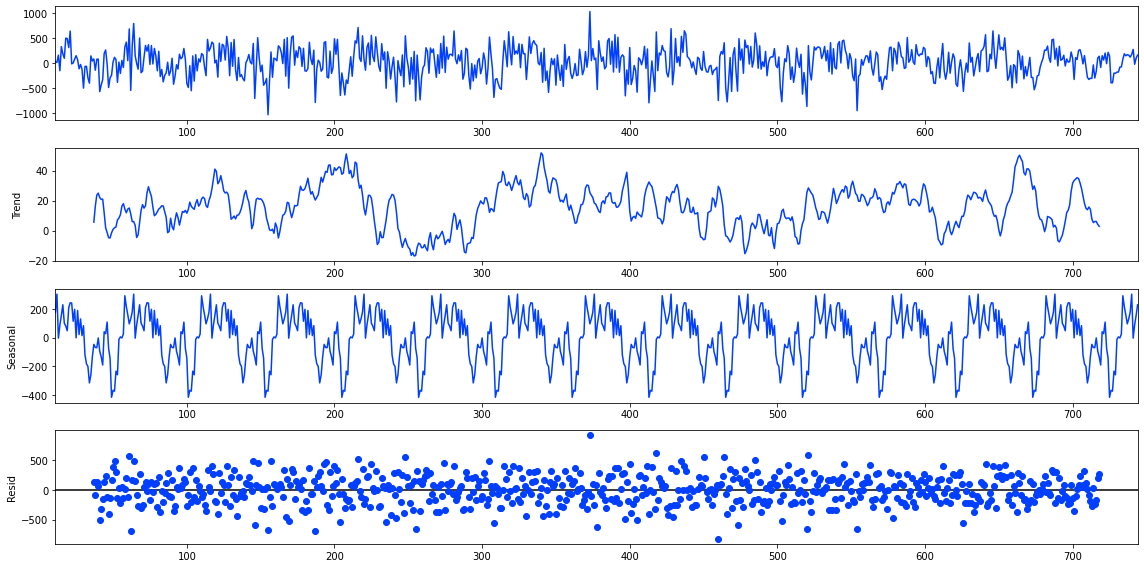

In [217]:
#Descomposicion de la serie de tiempo
descomposicionDif = seasonal_decompose(datosDif, period = 52)
graficaDif = descomposicionDif.plot()

##Modelo Arima

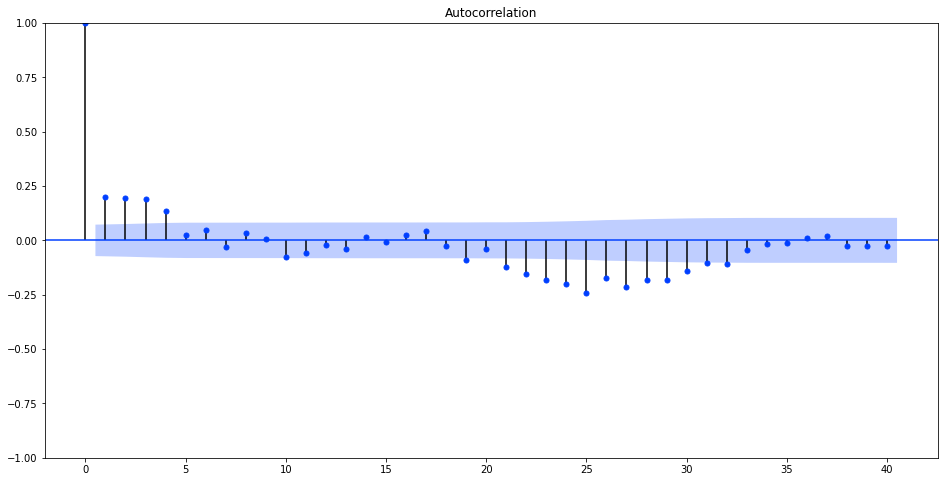

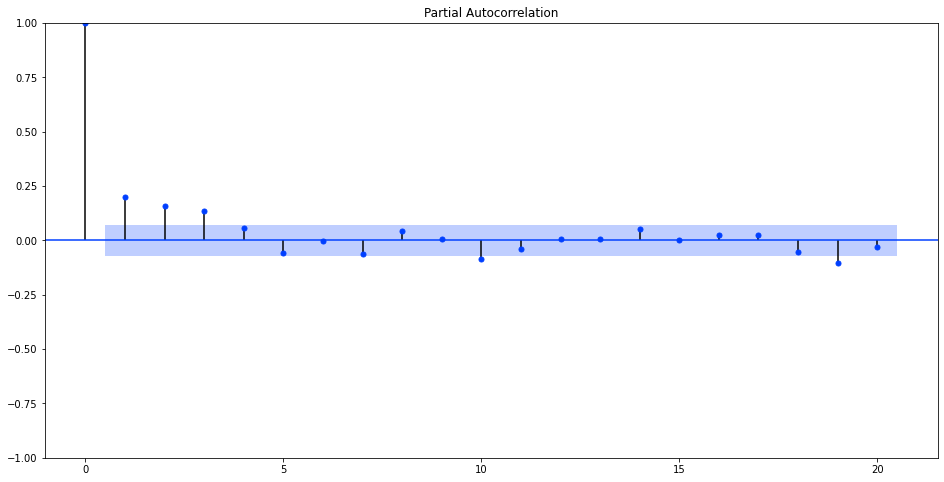

In [218]:
## Modelo Arima
fig = sm.graphics.tsa.plot_acf(datosDif.values.squeeze(), lags = 40)
fig = sm.graphics.tsa.plot_pacf(datosDif, lags = 20)

In [219]:
#Primero Correlación parcial
#Segundo Transformaciones
#Tercero Autocorrelación
modelo = ARIMA(datosDif, order=(3,1,4))
modeloAjustado = modelo.fit()

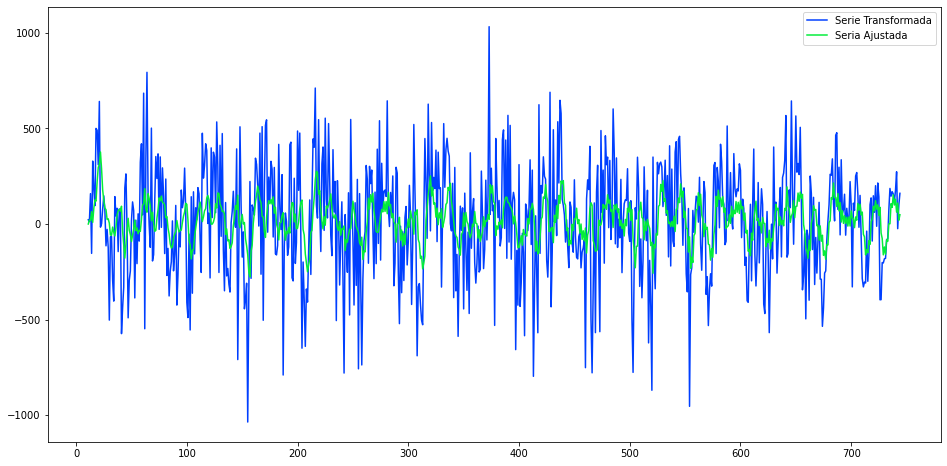

In [220]:
plt.plot(datosDif, label = 'Serie Transformada')
plt.plot(modeloAjustado.fittedvalues, label = 'Seria Ajustada')
plt.legend()
plt.show()

In [221]:
ajustes = pd.DataFrame(modeloAjustado.fittedvalues)
ajustes = ajustes.rename(columns = {0:'Gasolina'})
ajustes

Gasolina
11     0.000000
12    20.581218
13    16.794724
14    64.577813
15     8.722103
..          ...
740  129.867488
741   62.093717
742  109.802311
743   19.736474
744   48.607769

[734 rows x 1 columns]

In [225]:
predicciones = (ajustes['Gasolina']+mediaMovil)
predicciones = predicciones.dropna()
predicciones

11     6933.916667
12     6984.081218
13     7042.961391
14     7117.161146
15     7075.638770
          ...     
740    9124.450821
741    9094.843717
742    9158.135645
743    9097.236474
744    9157.024435
Length: 734, dtype: float64

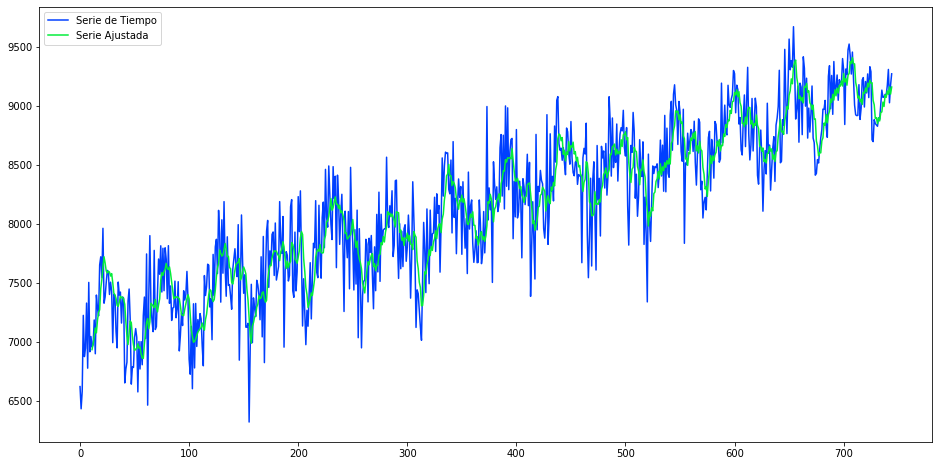

In [226]:
plt.plot(datos, label='Serie de Tiempo')
plt.plot(predicciones, label='Serie Ajustada')
plt.legend()
plt.show()

In [227]:
m = 52
alfa = 1/(2*m)

##Suavización Exponencial

In [228]:
datosSES = SimpleExpSmoothing(datos).fit(smoothing_level = alfa, optimized = False).fittedvalues
datos.head()

0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

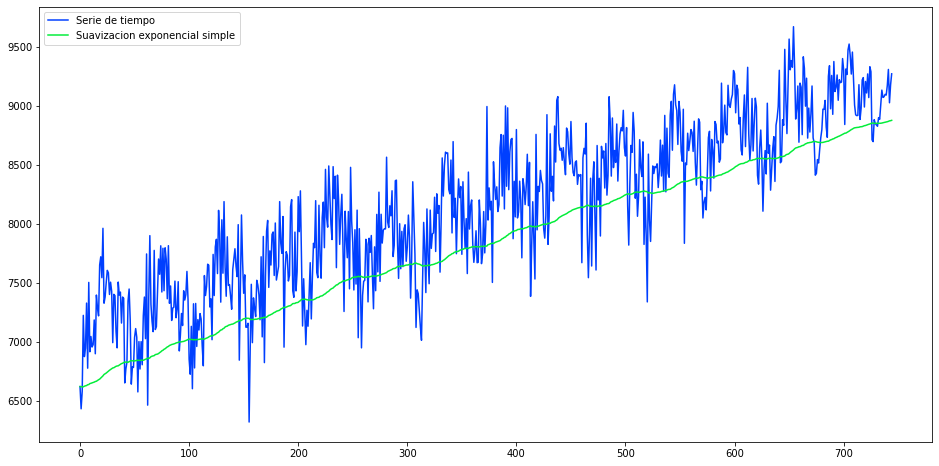

In [229]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSES, label = 'Suavizacion exponencial simple')
plt.legend()
plt.show()

In [230]:
## Suavizacion exponencial holt-winters
datosSEHW1 = ExponentialSmoothing(datos, trend = 'add').fit().fittedvalues
datos.head()

0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

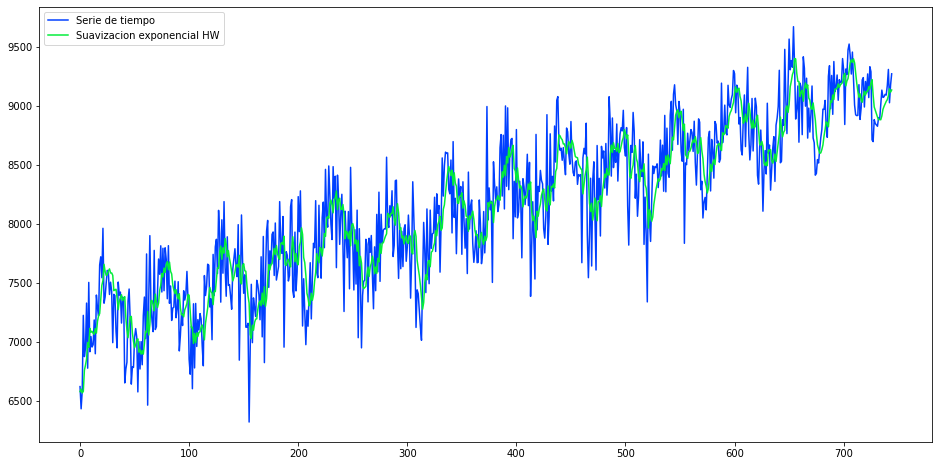

In [231]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW1, label = 'Suavizacion exponencial HW')
plt.legend()
plt.show()

In [232]:
datosSEHW2 = ExponentialSmoothing(datos, trend = 'mul').fit().fittedvalues
datos.head()

0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

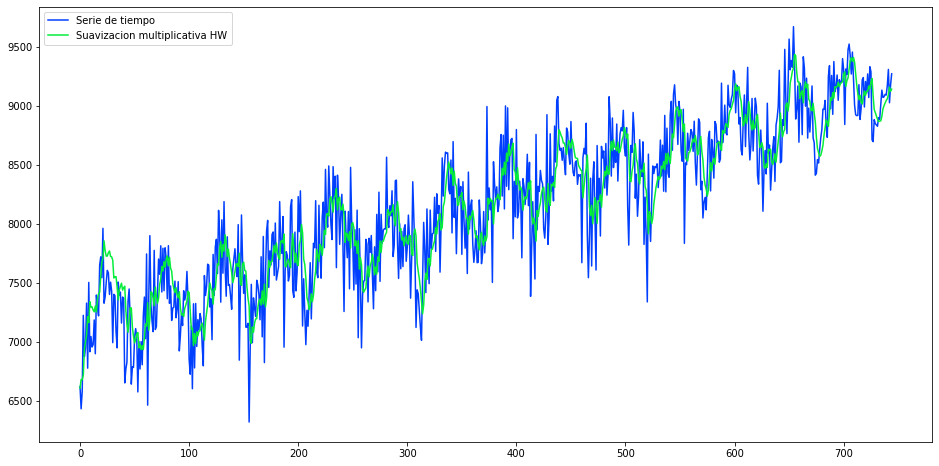

In [233]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW2, label = 'Suavizacion multiplicativa HW')
plt.legend()
plt.show()

In [234]:
datosSEHW3 = ExponentialSmoothing(datos, trend = 'mul', seasonal = 'add', seasonal_periods = 4).fit().fittedvalues
datos.head()

0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

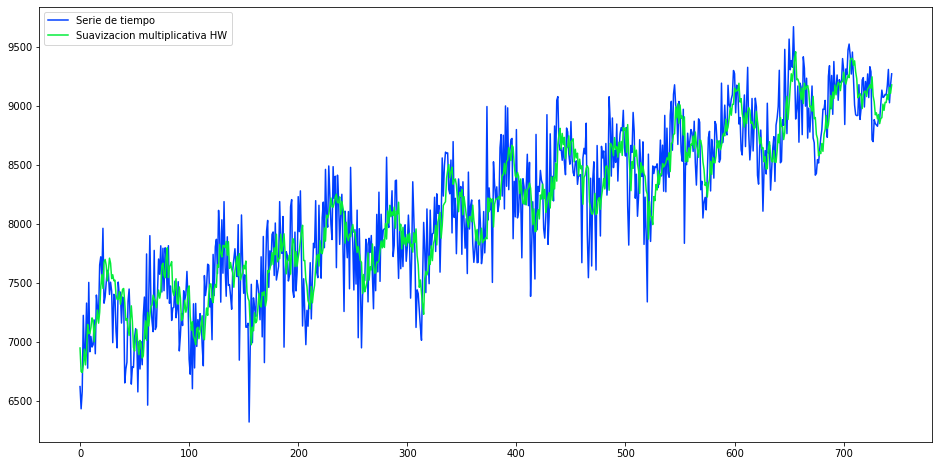

In [235]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSEHW3, label = 'Suavizacion multiplicativa HW')
plt.legend()
plt.show()

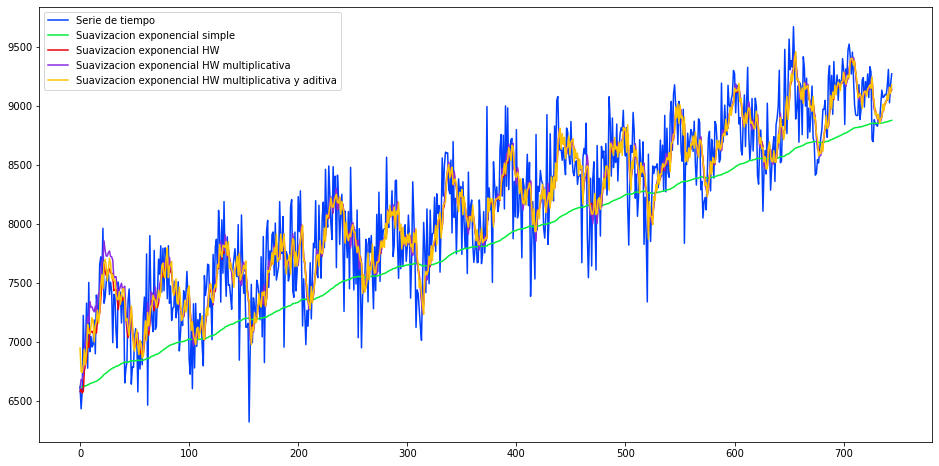

In [236]:
plt.plot(datos, label = 'Serie de tiempo')
plt.plot(datosSES, label = 'Suavizacion exponencial simple')
plt.plot(datosSEHW1, label = 'Suavizacion exponencial HW')
plt.plot(datosSEHW2, label = 'Suavizacion exponencial HW multiplicativa')
plt.plot(datosSEHW3, label = 'Suavizacion exponencial HW multiplicativa y aditiva')

plt.legend()
plt.show()

In [248]:
datosAjuste = datos[:700]
datosValidacion = datos[700:]

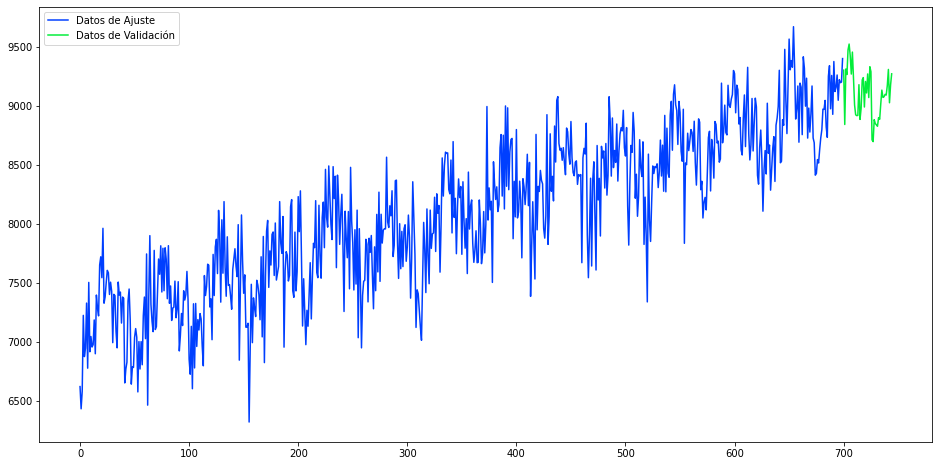

In [249]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.legend()
plt.show()

In [251]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add',seasonal_periods=52).fit()
predicciones= modeloAjustado.forecast(56)

In [252]:
predicciones

700    10197.381819
701    10093.293232
702    10314.090094
703    10224.339546
704    10317.743654
705    10239.328762
706    10318.708363
707    10188.948361
708    10109.765184
709    10122.404609
710    10003.119427
711    10070.175514
712    10218.568756
713    10345.490415
714    10284.261349
715    10330.194068
716    10372.478209
717    10273.261479
718    10186.428432
719    10198.222757
720    10464.396721
721    10460.386803
722    10589.864404
723    10486.163258
724    10379.594691
725    10122.941530
726    10177.934717
727    10117.450948
728    10272.260836
729    10240.236171
730    10440.582293
731    10517.840797
732    10533.071437
733    10562.715343
734    10831.703714
735    10784.940390
736    10780.843129
737    10714.060946
738    10840.944656
739    10960.098026
740    11120.881243
741    10890.410455
742    11029.704577
743    11159.110254
744    11286.188621
745    11213.330308
746    11241.054458
747    11228.186780
748    11451.806762
749    11534.099159


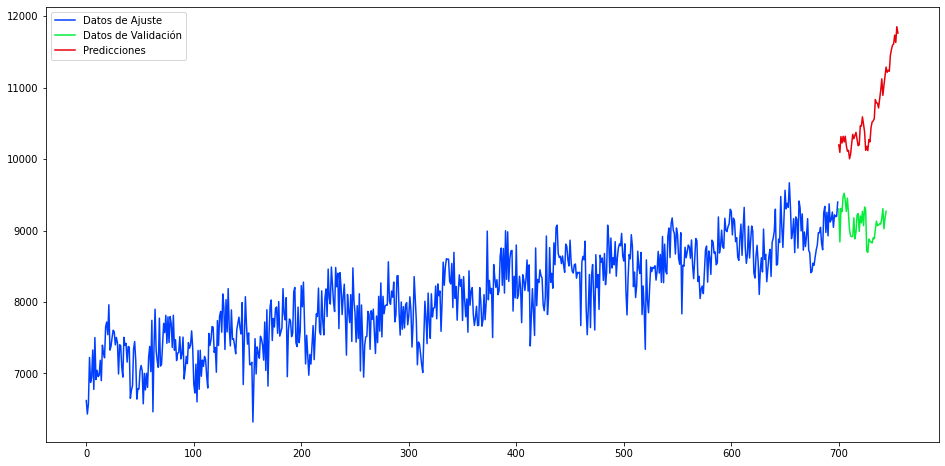

In [253]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

##Auto ARIMA

In [242]:
modeloAuto = pm.auto_arima(datos, seasonal=True, stationary=False, start_q=1, start_p=1, d=1)

In [243]:
modeloAuto.params()

ma.L1        -0.732633
sigma2    96307.765182
dtype: float64

In [244]:
modeloAuto.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [245]:
predAuto = modeloAuto.predict(56)

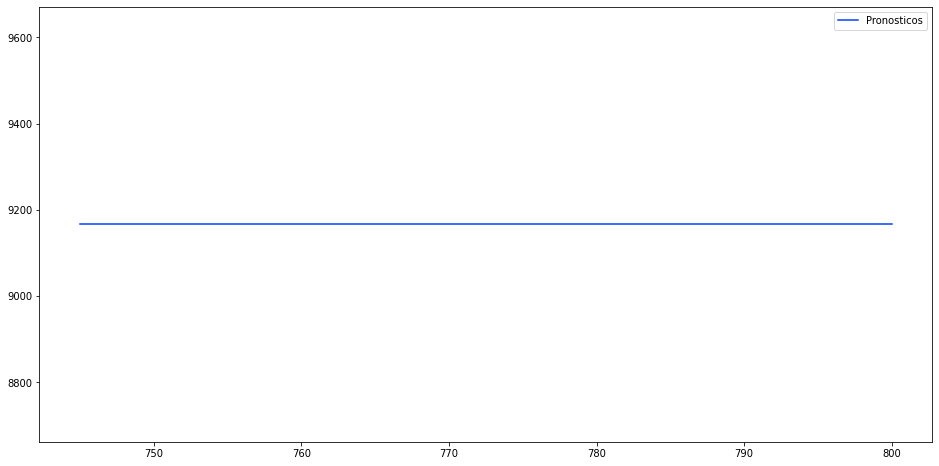

In [246]:
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

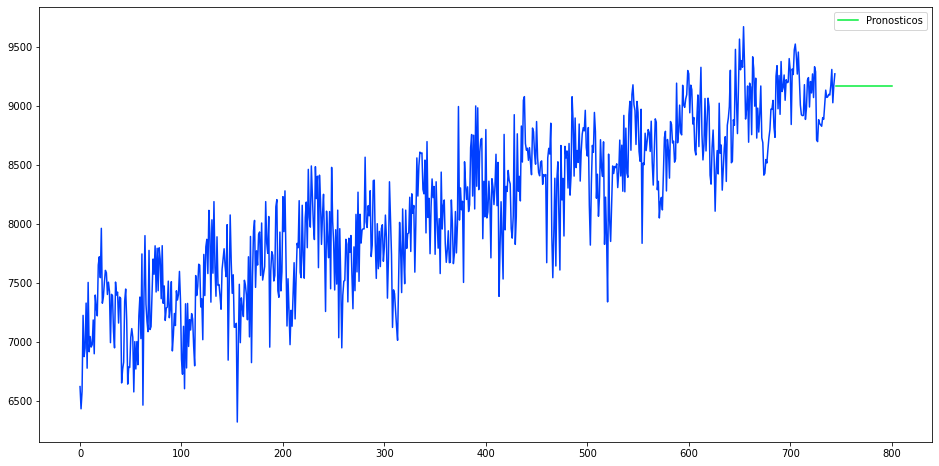

In [247]:
plt.figure(figsize= (16,8))
plt.plot(datos)
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

#Punto 4

##Exploracion de datos

In [370]:
###Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import warnings
import pmdarima as pm

In [371]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('seaborn-bright')

In [372]:
datos = pm.datasets.load_lynx(as_series = True)
datos

1821     269.0
1822     321.0
1823     585.0
1824     871.0
1825    1475.0
         ...  
1930     662.0
1931    1000.0
1932    1590.0
1933    2657.0
1934    3396.0
Length: 114, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

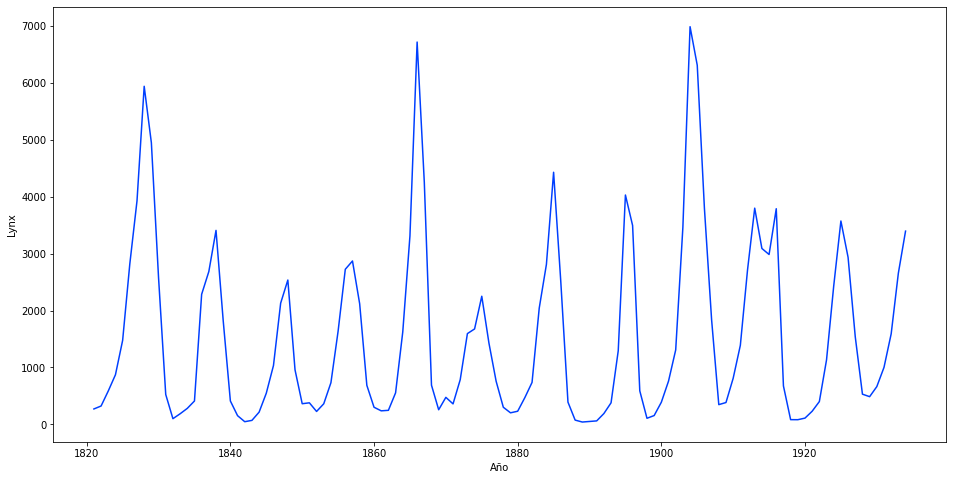

In [373]:
plt.xlabel('Año')
plt.ylabel('Lynx')
plt.plot(datos)
plt.show

In [374]:
#Identificar estacionariedad por mecanismos graficos
mediaMovil = datos.rolling(window=1).mean()
desviacionMediaMovil = datos.rolling(window=1).std()


In [375]:
print('Test de Dickey - Fuller: ')
dftest = adfuller(datos,autolag = 'AIC')
dfoutput= pd.Series(dftest[0:4],index=['Estadistico T','Valor p','Retrasos usados','Numero de observaciones'])
for key,value in dftest[4].items():
  dfoutput['Valores Criticos(%s)' %key]=value
print(dfoutput)

Test de Dickey - Fuller: 
Estadistico T               -2.996304
Valor p                      0.035241
Retrasos usados              7.000000
Numero de observaciones    106.000000
Valores Criticos(1%)        -3.493602
Valores Criticos(5%)        -2.889217
Valores Criticos(10%)       -2.581533
dtype: float64


##Transformacion

### No se hace Necesaria la transfomacion ya que despues de hacer el test de Dickey-Fuller a los datos su Estadistico T es negativo y su valor p es menor que 0.05. Por tanto usamos los datos sin ser transformados 

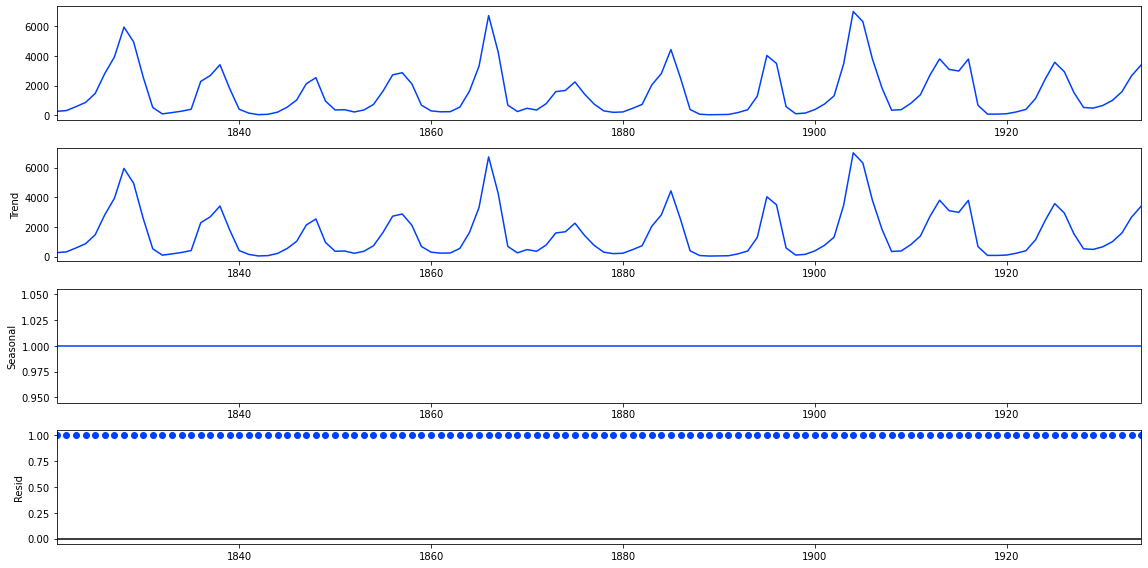

In [376]:
#Descomposicion de la serie de Tiempo
descomposicion = seasonal_decompose(datos, model = 'multiplicative',period=1)
grafica = descomposicion.plot()

##Modelo Arima

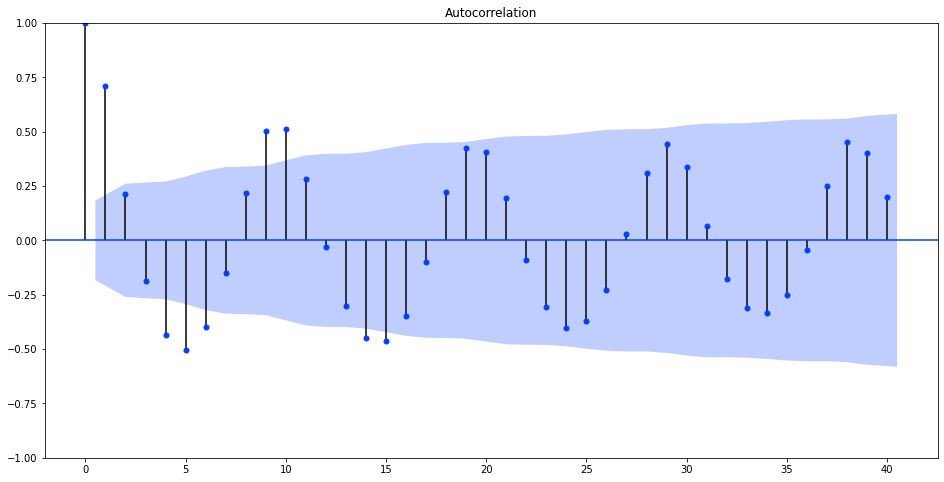

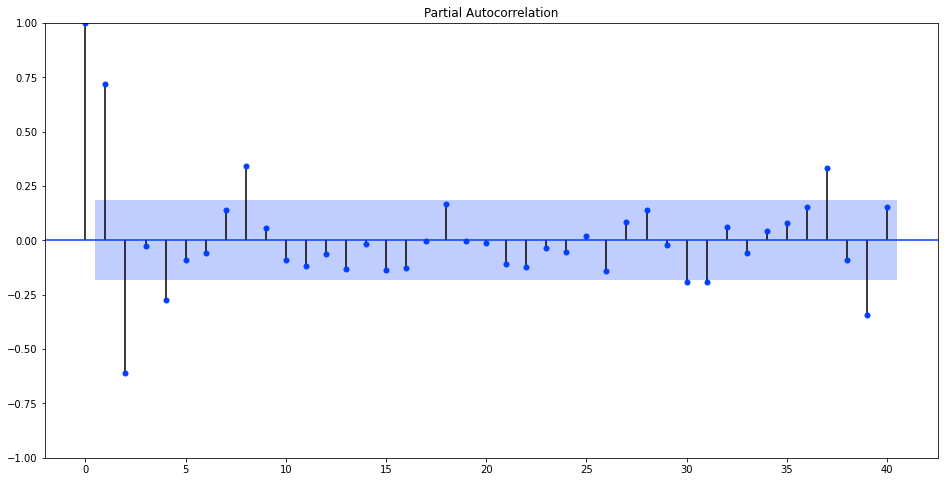

In [385]:
#Modelo ARIMA
fig = sm.graphics.tsa.plot_acf(datos.dropna().values.squeeze(),lags=40)
fig = sm.graphics.tsa.plot_pacf(datos.dropna(),lags=40)

In [386]:
modelo = ARIMA(datos.dropna(),order = (2,0,1))
modeloAjustado = modelo.fit()

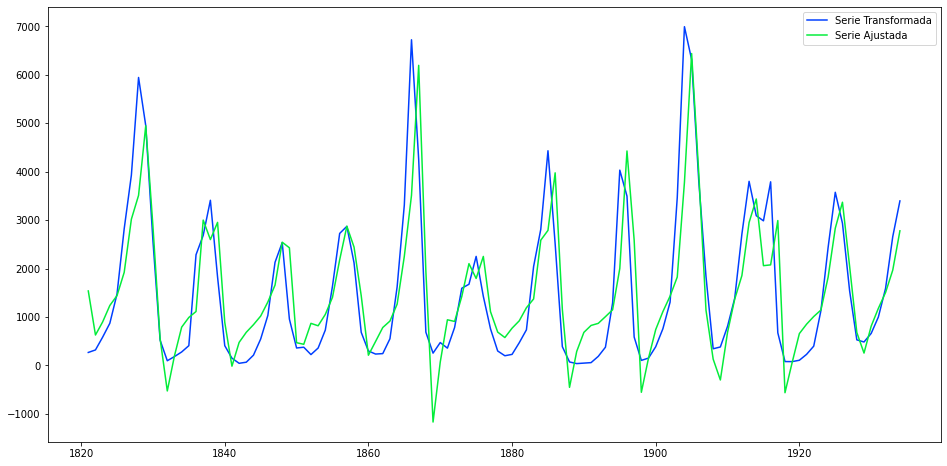

In [387]:
plt.plot(datos.dropna(), label='Serie Transformada')
plt.plot(modeloAjustado.fittedvalues, label='Serie Ajustada')
plt.legend()
plt.show()

In [388]:
modeloAjustado

In [389]:
ajustes = pd.DataFrame(modeloAjustado.fittedvalues)
ajustes = ajustes.rename(columns = {0:'Lynx'})
ajustes

Lynx
1821  1538.017726
1822   628.910923
1823   898.976830
1824  1238.372945
1825  1442.461040
...           ...
1930   811.844104
1931  1179.710933
1932  1505.421469
1933  1966.140060
1934  2779.141559

[114 rows x 1 columns]

In [390]:
predicciones = ajustes
predicciones.dropna()

Lynx
1821  1538.017726
1822   628.910923
1823   898.976830
1824  1238.372945
1825  1442.461040
...           ...
1930   811.844104
1931  1179.710933
1932  1505.421469
1933  1966.140060
1934  2779.141559

[114 rows x 1 columns]

[]

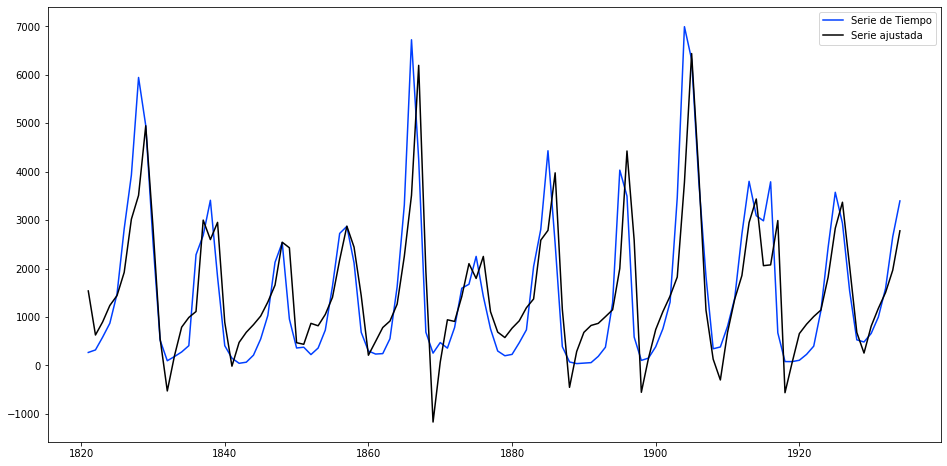

In [391]:
plt.plot(datos, label = 'Serie de Tiempo')
plt.plot(predicciones, label = 'Serie ajustada', color = 'black')
plt.legend()
plt.plot()

In [392]:
#Periodicidad 
m = 1
alfa = 1/(2*m)

##Suavizacion Exponencial

In [ ]:
datos = datos.to_frame(name='Lynx')
datos

Lynx
1821   269.0
1822   321.0
1823   585.0
1824   871.0
1825  1475.0
...      ...
1930   662.0
1931  1000.0
1932  1590.0
1933  2657.0
1934  3396.0

[114 rows x 1 columns]

In [ ]:
datos['SES'] = SimpleExpSmoothing(datos['Lynx']).fit(smoothing_level=alfa, optimized=False).fittedvalues
datos.head()

Lynx    SES
1821   269.0  269.0
1822   321.0  269.0
1823   585.0  295.0
1824   871.0  440.0
1825  1475.0  655.5

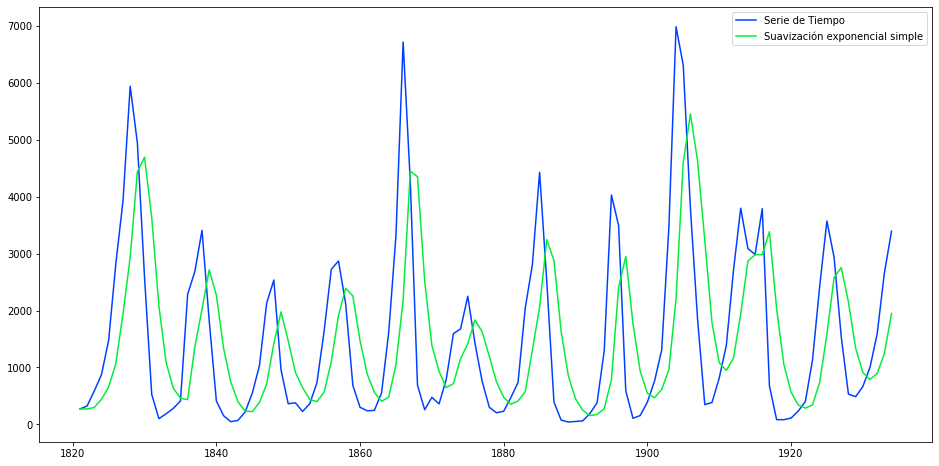

In [ ]:
plt.plot(datos['Lynx'],label='Serie de Tiempo')
plt.plot(datos['SES'],label='Suavización exponencial simple')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW1'] = ExponentialSmoothing(datos['Lynx'] ,trend = 'add').fit().fittedvalues
datos.head()

Lynx    SES        SEHW1
1821   269.0  269.0   -93.690909
1822   321.0  269.0   824.111662
1823   585.0  295.0   868.581315
1824   871.0  440.0  1124.799077
1825  1475.0  655.5  1404.667608

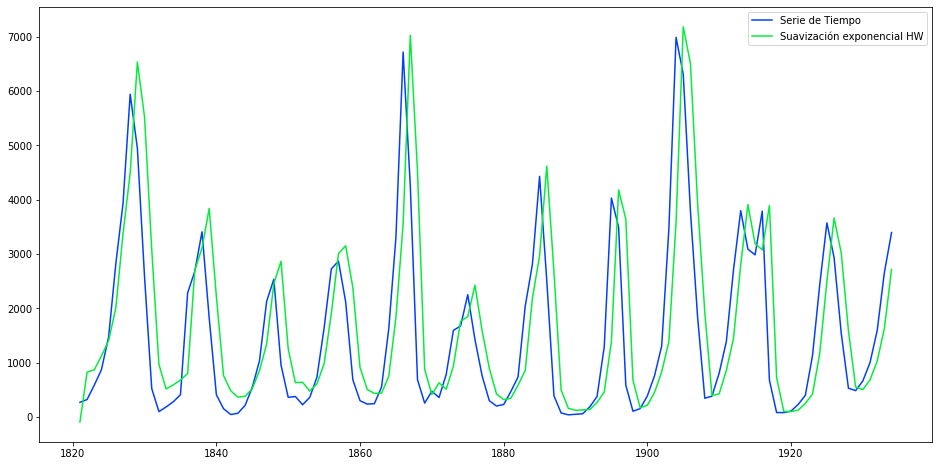

In [ ]:
plt.plot(datos['Lynx'],label='Serie de Tiempo')
plt.plot(datos['SEHW1'],label='Suavización exponencial HW')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW2'] = ExponentialSmoothing(datos['Lynx'] ,trend = 'mul').fit().fittedvalues
datos.head()

Lynx    SES        SEHW1         SEHW2
1821   269.0  269.0   -93.690909  1.459208e-03
1822   321.0  269.0   824.111662  1.697548e+05
1823   585.0  295.0   868.581315  7.234566e+05
1824   871.0  440.0  1124.799077  2.539442e+06
1825  1475.0  655.5  1404.667608  8.009077e+06

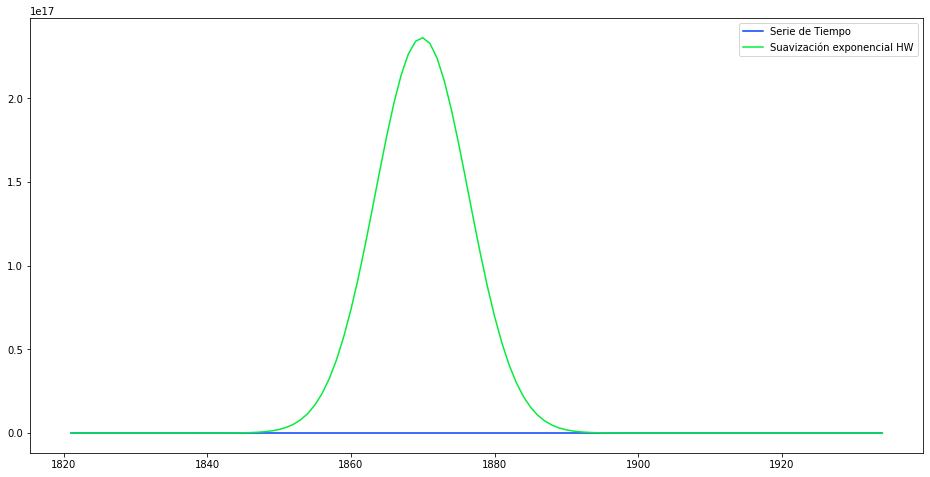

In [ ]:
plt.plot(datos['Lynx'],label='Serie de Tiempo')
plt.plot(datos['SEHW2'],label='Suavización exponencial HW')
plt.legend()
plt.show()

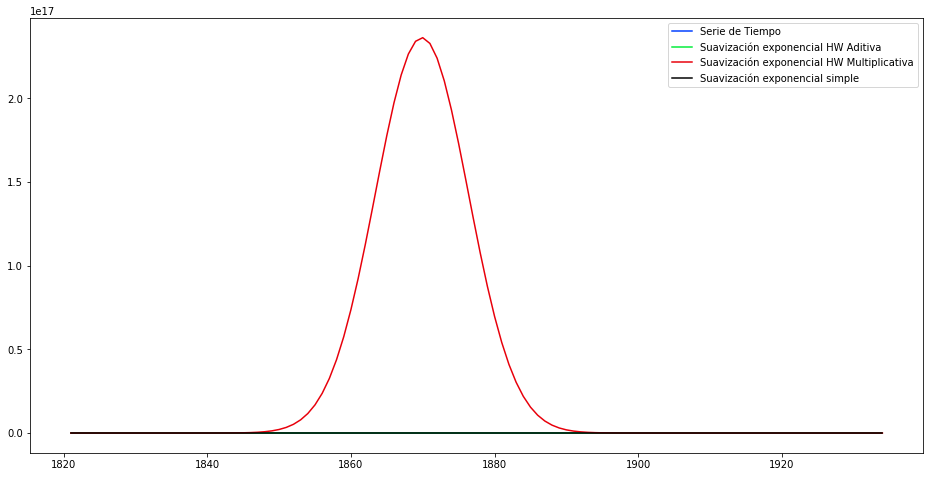

In [ ]:
plt.plot(datos['Lynx'],label='Serie de Tiempo')
plt.plot(datos['SEHW1'],label='Suavización exponencial HW Aditiva')
plt.plot(datos['SEHW2'],label='Suavización exponencial HW Multiplicativa')
plt.plot(datos['SES'],label='Suavización exponencial simple', color='black')
plt.legend()
plt.show()

In [ ]:
datos

Lynx          SES        SEHW1         SEHW2
1821   269.0   269.000000   -93.690909  1.459208e-03
1822   321.0   269.000000   824.111662  1.697548e+05
1823   585.0   295.000000   868.581315  7.234566e+05
1824   871.0   440.000000  1124.799077  2.539442e+06
1825  1475.0   655.500000  1404.667608  8.009077e+06
...      ...          ...          ...           ...
1930   662.0   911.509568   502.515994  3.759161e+04
1931  1000.0   786.754784   682.137555  4.006150e+04
1932  1590.0   893.377392  1026.838324  5.525936e+04
1933  2657.0  1241.688696  1628.886688  8.394498e+04
1934  3396.0  1949.344348  2717.796641  1.352226e+05

[114 rows x 4 columns]

In [ ]:
datosAjuste = datos.Lynx[1:100]
datosValidacion = datos.Lynx[100:]

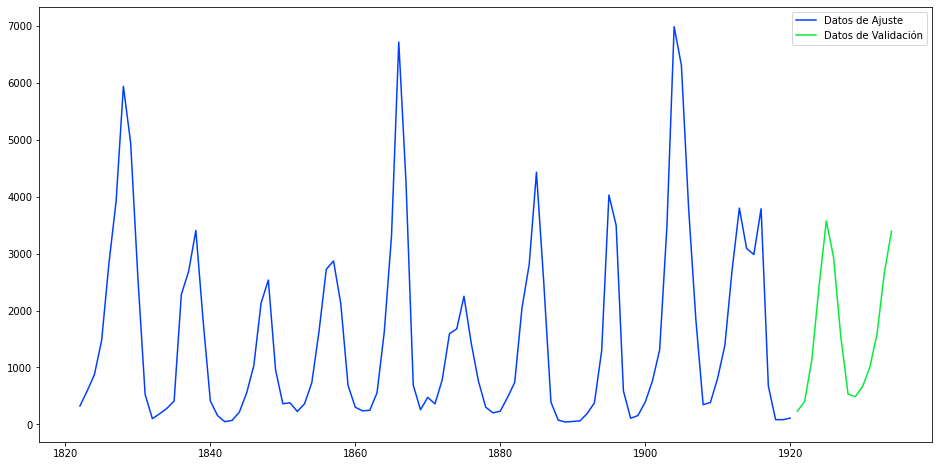

In [ ]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.legend()
plt.show()

In [ ]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add',seasonal_periods=4).fit()
predicciones= modeloAjustado.forecast(56)

In [ ]:
predicciones

1921     52.592051
1922    -24.593840
1923   -491.353598
1924    131.568430
1925     72.217331
1926     -6.030657
1927   -473.795032
1928    148.176749
1929     87.926827
1930      8.828660
1931   -459.739883
1932    161.471249
1933    100.501845
1934     20.723134
1935   -448.489124
1936    172.113131
1937    110.567801
1938     30.244332
1939   -439.483201
1940    180.631664
1941    118.625322
1942     37.865789
1943   -432.274208
1944    187.450515
1945    125.075145
1946     43.966556
1947   -426.503608
1948    192.908818
1949    130.238050
1950     48.850051
1951   -421.884401
1952    197.278038
1953    134.370814
1954     52.759155
1955   -418.186854
1956    200.775479
1957    137.678977
1958     55.888284
1959   -415.227069
1960    203.575084
1961    140.327071
1962     58.393066
1963   -412.857843
1964    205.816091
1965    142.446797
1966     60.398075
1967   -410.961342
1968    207.609955
1969    144.143579
1970     62.003030
1971   -409.443246
1972    209.045893
1973    145.

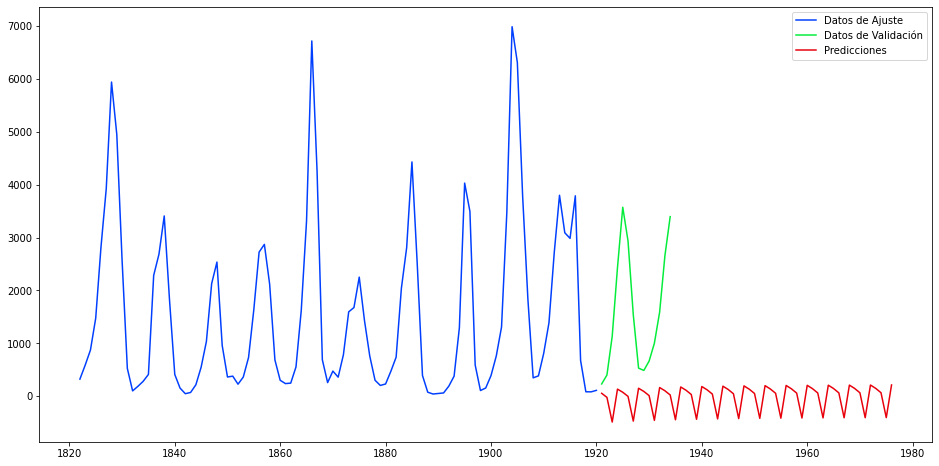

In [ ]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

##Auto Arima

In [ ]:
modeloAuto = pm.auto_arima(datos.Lynx, seasonal=True, stationary=False, start_q=1, start_p=1, d=1)

In [ ]:
modeloAuto.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [ ]:
predAuto = modeloAuto.predict(56)

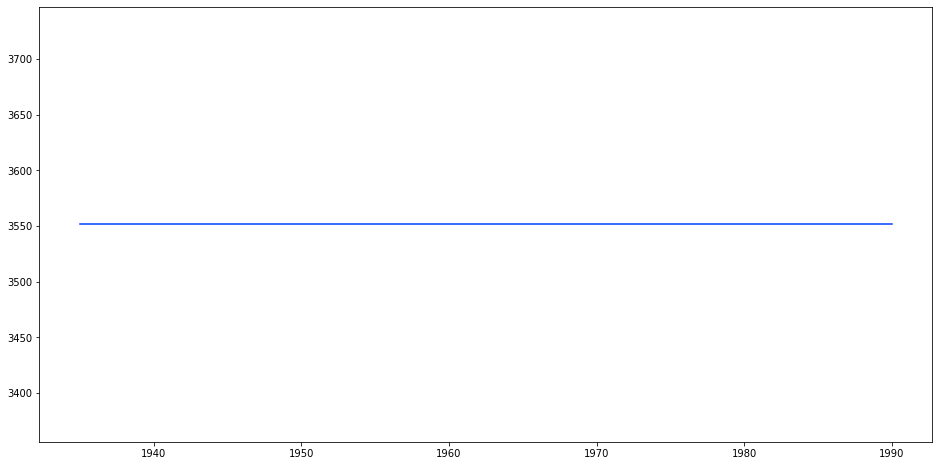

In [ ]:
plt.plot(predAuto)

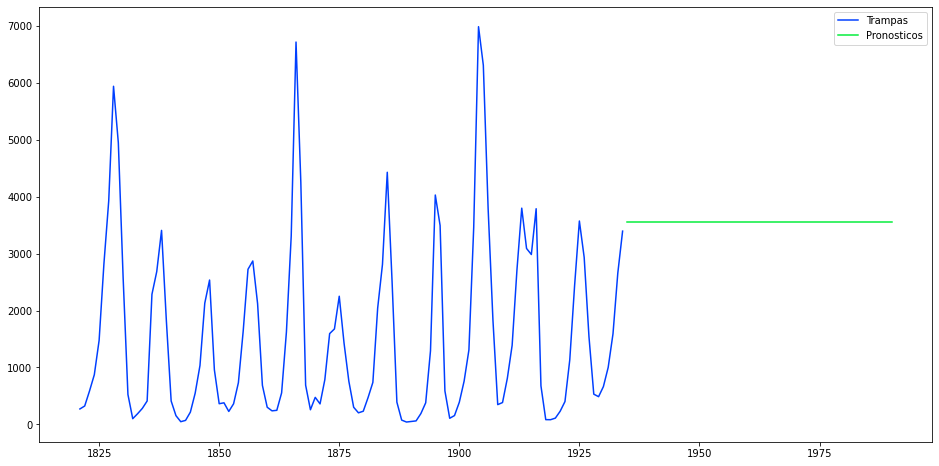

In [ ]:
plt.figure(figsize= (16,8))
plt.plot(datos.Lynx, label='Trampas')
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

#Punto 5

##Exploración de datos

In [ ]:
###Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm

import warnings

In [ ]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('seaborn-bright')

In [ ]:
datos = pm.datasets.load_msft()
print(datos.shape)
datos.head()

(7983, 7)


Date     Open     High      Low    Close      Volume  OpenInt
0  1986-03-13  0.06720  0.07533  0.06720  0.07533  1371330506        0
1  1986-03-14  0.07533  0.07533  0.07533  0.07533   409569463        0
2  1986-03-17  0.07533  0.07533  0.07533  0.07533   176995245        0
3  1986-03-18  0.07533  0.07533  0.07533  0.07533    90067008        0
4  1986-03-19  0.07533  0.07533  0.07533  0.07533    63655515        0

In [ ]:
datos['Date'] = pd.to_datetime(datos['Date'], infer_datetime_format=True)
datos.set_index(['Date'], inplace=True)
#datos.rename(columns={'#Passengers':'Passengers'},inplace=True)
datos.head()

Open     High      Low    Close      Volume  OpenInt
Date                                                               
1986-03-13  0.06720  0.07533  0.06720  0.07533  1371330506        0
1986-03-14  0.07533  0.07533  0.07533  0.07533   409569463        0
1986-03-17  0.07533  0.07533  0.07533  0.07533   176995245        0
1986-03-18  0.07533  0.07533  0.07533  0.07533    90067008        0
1986-03-19  0.07533  0.07533  0.07533  0.07533    63655515        0

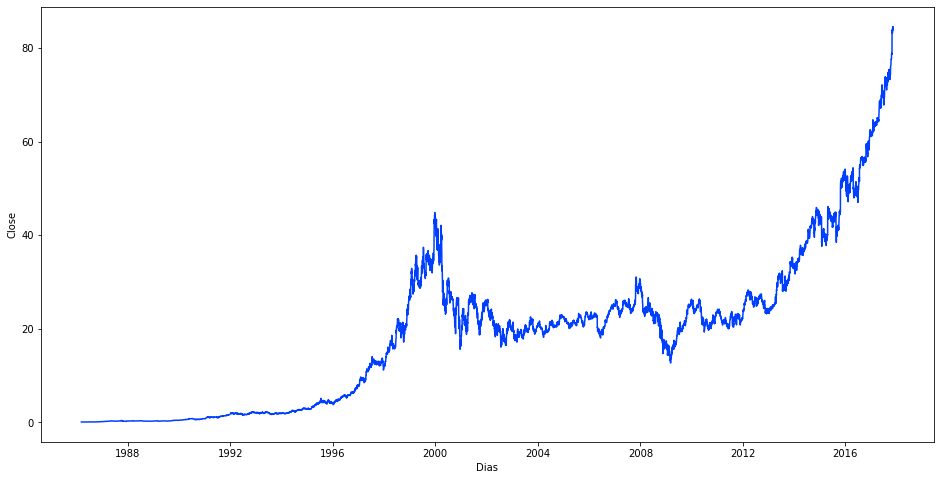

In [ ]:
#Gráfico de la serie
plt.xlabel('Dias')
plt.ylabel('Close')
plt.plot(datos.Close)
plt.show()

In [ ]:
#Identificar estacionariedad
mediaMovil = datos.Close.rolling(window = 12).mean()
desviacionMediaMovil = datos.Close.rolling(window = 12).std()

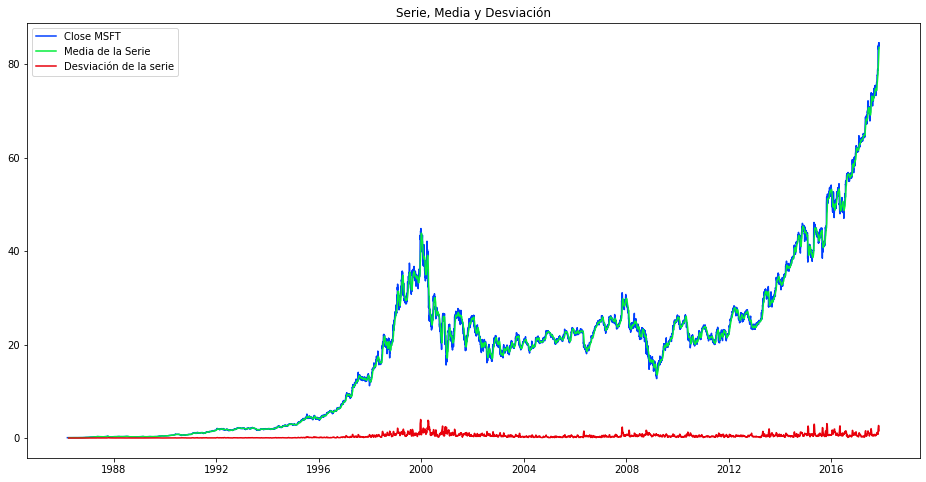

In [ ]:
plt.plot(datos.Close, label='Close MSFT')
plt.plot(mediaMovil, label='Media de la Serie')
plt.plot(desviacionMediaMovil, label='Desviación de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media y Desviación')
plt.show()

In [ ]:
print('Test de Dickey - Fuller:')
dftest = adfuller(datos.Close.dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estadistico','Valor P','Retrasos Usados','Número de Observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores Críticos (%s)'%key]=value

print(dfoutput)

Test de Dickey - Fuller:
Estadistico                   2.667362
Valor P                       0.999085
Retrasos Usados              36.000000
Número de Observaciones    7946.000000
Valores Críticos (1%)        -3.431173
Valores Críticos (5%)        -2.861904
Valores Críticos (10%)       -2.566964
dtype: float64


##Transformación 

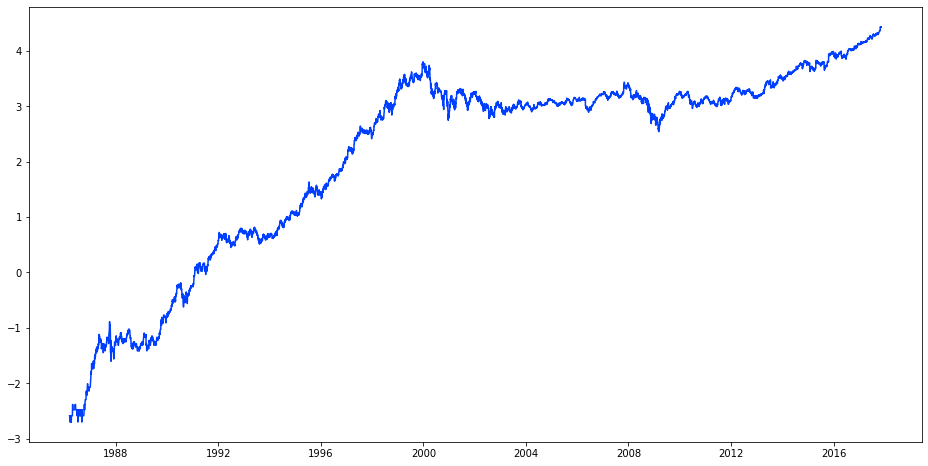

In [ ]:
#Aplicar Logaritmo
datosLog = np.log(datos.Close)
plt.plot(datosLog)
plt.show()

In [ ]:
#Identificar estacionariedad
mediaMovilLog = datosLog.rolling(window = 12).mean()
desviacionMediaMovilLog = datosLog.rolling(window = 12).std()

In [ ]:
print('Test de Dickey - Fuller:')
dftest = adfuller(datosLog, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estadistico','Valor P','Retrasos Usados','Número de Observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores Críticos (%s)'%key]=value

print(dfoutput)

Test de Dickey - Fuller:
Estadistico                  -3.188706
Valor P                       0.020648
Retrasos Usados               4.000000
Número de Observaciones    7978.000000
Valores Críticos (1%)        -3.431170
Valores Críticos (5%)        -2.861902
Valores Críticos (10%)       -2.566963
dtype: float64


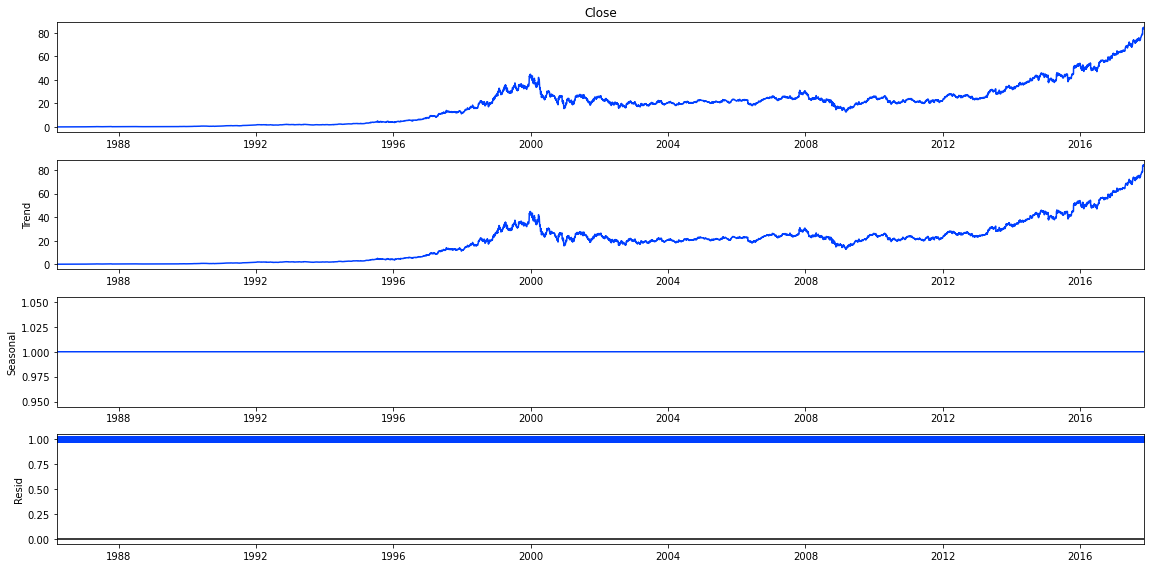

In [ ]:
#Descomposición de la serie de tiempo
descomposicion = seasonal_decompose(datos.Close.dropna(), model='multiplicative', period=1)
grafica = descomposicion.plot()

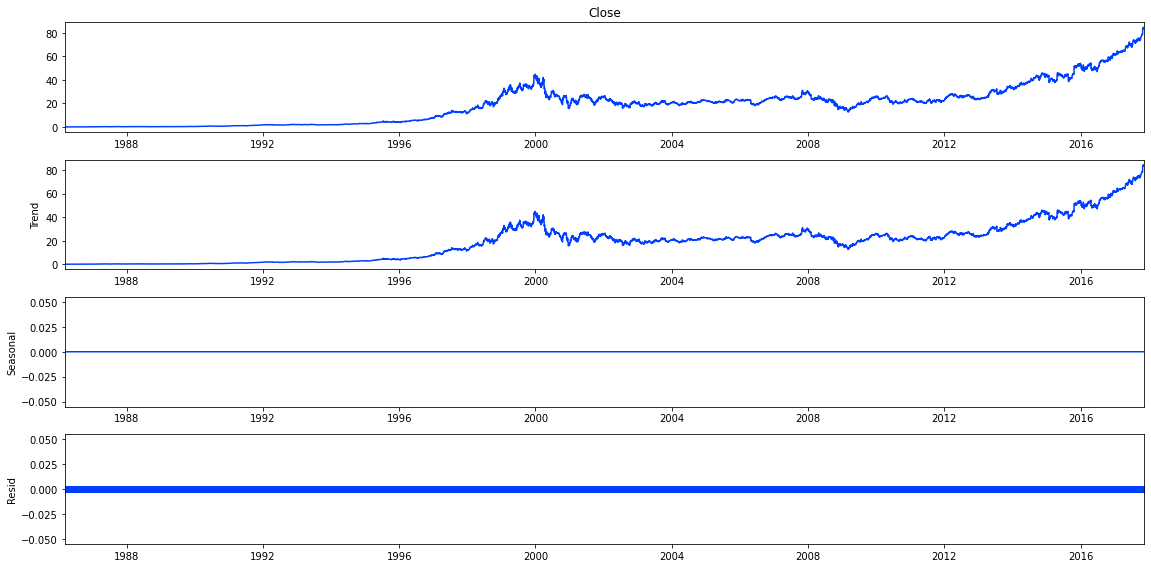

In [ ]:
#Descomposición de la serie de tiempo
descomposicionDif = seasonal_decompose(datos.Close.dropna(), period=1)
graficaDif = descomposicionDif.plot()

##Modelo Arima

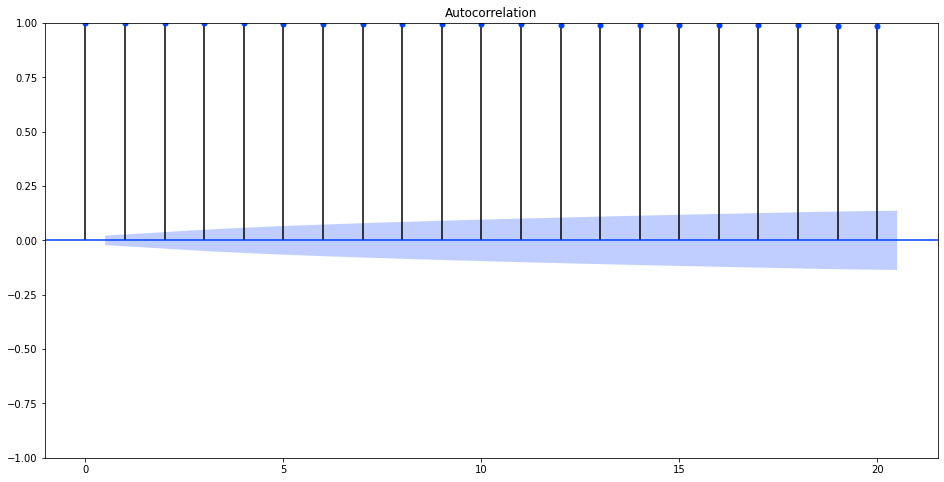

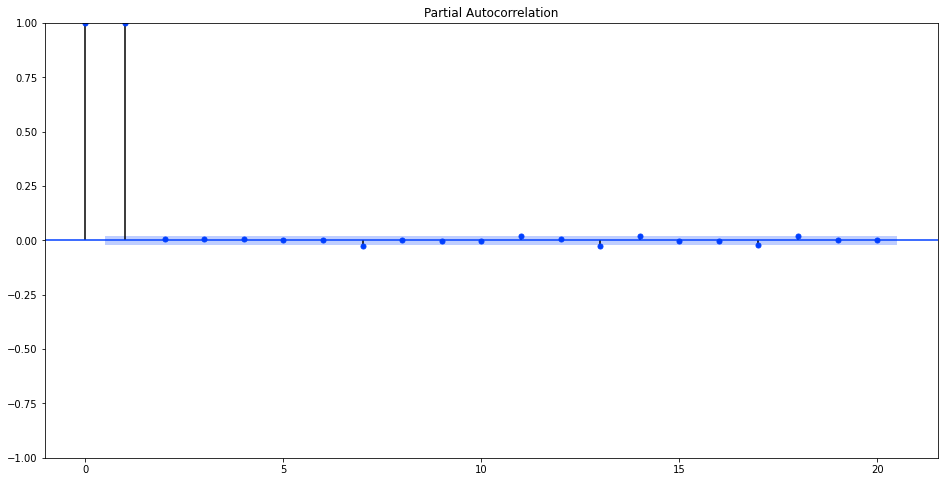

In [ ]:
#Modelo ARIMA
fig= sm.graphics.tsa.plot_acf(datosLog.dropna().values.squeeze(), lags=20)

fig= sm.graphics.tsa.plot_pacf(datosLog.dropna(), lags=20)

In [ ]:
#Primero Correlación parcial
#Segundo Transformaciones
#Tercero Autocorrelación
modelo = ARIMA(datosLog.dropna(), order=(1,1,20))
modeloAjustado = modelo.fit()

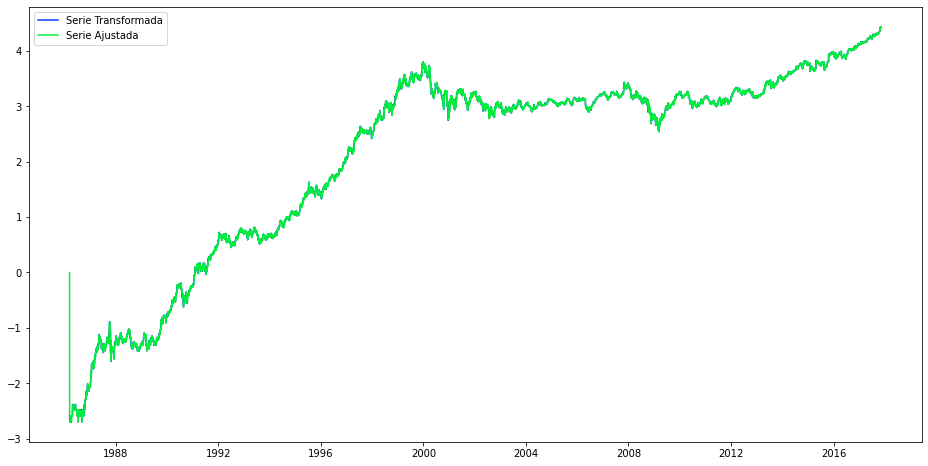

In [ ]:
plt.plot(datosLog.dropna(), label='Serie Transformada')
plt.plot(modeloAjustado.fittedvalues, label='Serie Ajustada')
plt.legend()
plt.show()

In [ ]:
modeloAjustado

In [ ]:
ajustes = pd.DataFrame(modeloAjustado.fittedvalues)
ajustes = ajustes.rename(columns = {0:'Close'})
ajustes

Sales
Date                
1986-03-13  0.000000
1986-03-14 -2.585877
1986-03-17 -2.585877
1986-03-18 -2.585877
1986-03-19 -2.585877
...              ...
2017-11-06  4.432963
2017-11-07  4.435745
2017-11-08  4.433788
2017-11-09  4.438278
2017-11-10  4.431733

[7983 rows x 1 columns]

In [ ]:
ajustes=ajustes.drop('1986-03-13',axis=0)

In [ ]:
predicciones = np.exp(ajustes)
predicciones = predicciones.dropna()
predicciones

Sales
Date                 
1986-03-14   0.075330
1986-03-17   0.075330
1986-03-18   0.075330
1986-03-19   0.075330
1986-03-20   0.075330
...               ...
2017-11-06  84.180485
2017-11-07  84.414984
2017-11-08  84.249930
2017-11-09  84.629088
2017-11-10  84.076960

[7982 rows x 1 columns]

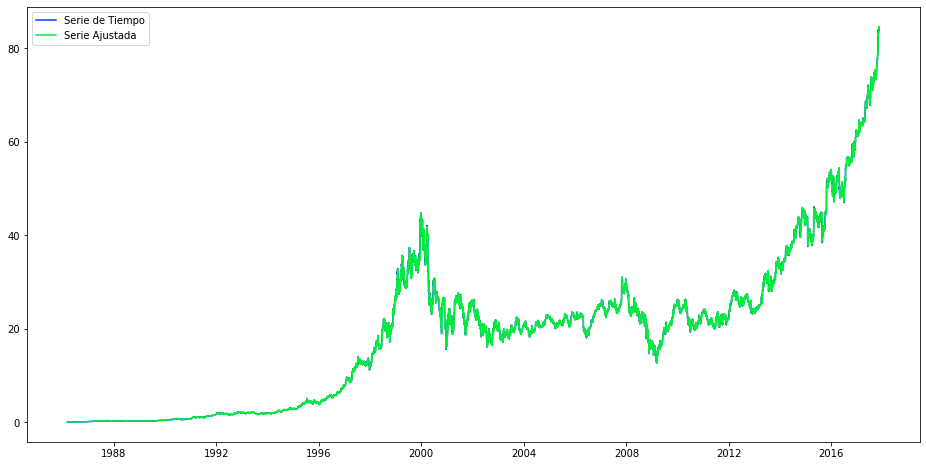

In [ ]:
plt.plot(datos.Close, label='Serie de Tiempo')
plt.plot(predicciones, label='Serie Ajustada')
plt.legend()
plt.show()

In [ ]:
#Periodicidad 
m = 1
alfa = 1/(2*m)

##Suavización Exponencial

In [ ]:
datos['SES'] = SimpleExpSmoothing(datos['Close']).fit(smoothing_level=alfa, optimized=False).fittedvalues
datos.head()

Open     High      Low    Close      Volume  OpenInt      SES
Date                                                                        
1986-03-13  0.06720  0.07533  0.06720  0.07533  1371330506        0  0.07533
1986-03-14  0.07533  0.07533  0.07533  0.07533   409569463        0  0.07533
1986-03-17  0.07533  0.07533  0.07533  0.07533   176995245        0  0.07533
1986-03-18  0.07533  0.07533  0.07533  0.07533    90067008        0  0.07533
1986-03-19  0.07533  0.07533  0.07533  0.07533    63655515        0  0.07533

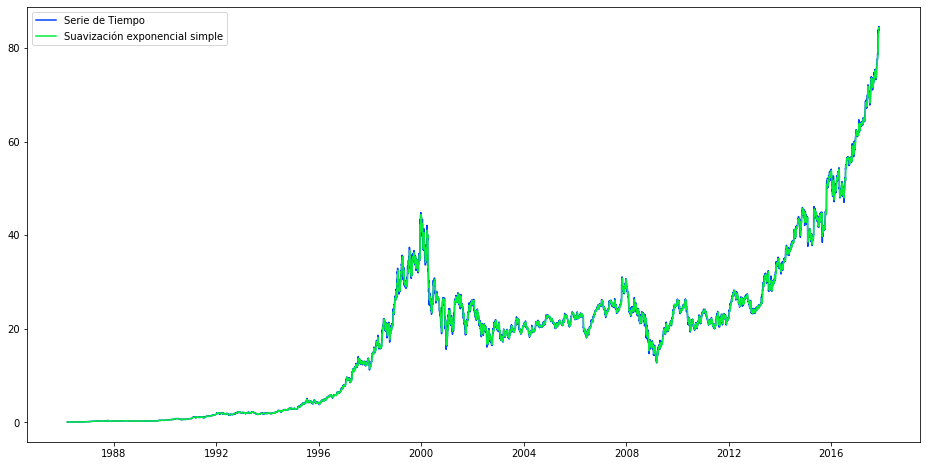

In [ ]:
plt.plot(datos['Close'],label='Serie de Tiempo')
plt.plot(datos['SES'],label='Suavización exponencial simple')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW1'] = ExponentialSmoothing(datos['Close'] ,trend = 'add').fit().fittedvalues
datos.head()

Open     High      Low    Close      Volume  OpenInt      SES  \
Date                                                                           
1986-03-13  0.06720  0.07533  0.06720  0.07533  1371330506        0  0.07533   
1986-03-14  0.07533  0.07533  0.07533  0.07533   409569463        0  0.07533   
1986-03-17  0.07533  0.07533  0.07533  0.07533   176995245        0  0.07533   
1986-03-18  0.07533  0.07533  0.07533  0.07533    90067008        0  0.07533   
1986-03-19  0.07533  0.07533  0.07533  0.07533    63655515        0  0.07533   

               SEHW1  
Date                  
1986-03-13  0.075334  
1986-03-14  0.077708  
1986-03-17  0.077756  
1986-03-18  0.077755  
1986-03-19  0.077753

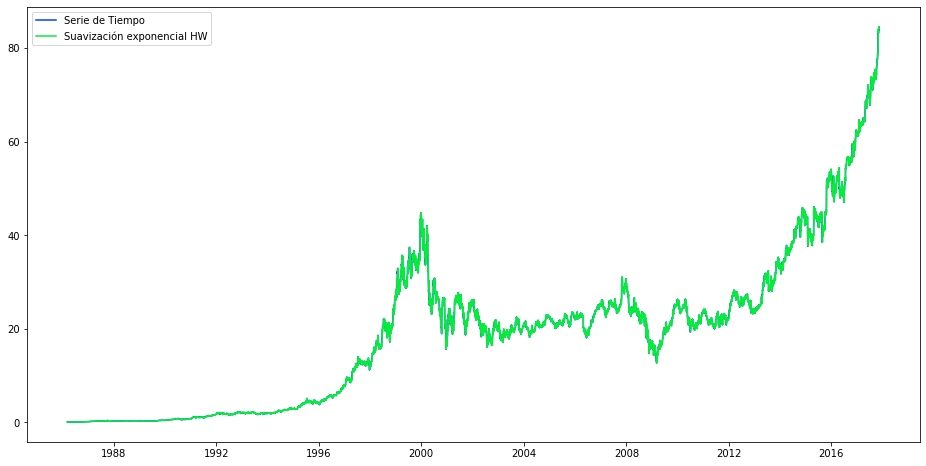

In [ ]:
plt.plot(datos['Close'],label='Serie de Tiempo')
plt.plot(datos['SEHW1'],label='Suavización exponencial HW')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW2'] = ExponentialSmoothing(datos['Close'] ,trend = 'mul').fit().fittedvalues
datos.head()

Open     High      Low    Close      Volume  OpenInt      SES  \
Date                                                                           
1986-03-13  0.06720  0.07533  0.06720  0.07533  1371330506        0  0.07533   
1986-03-14  0.07533  0.07533  0.07533  0.07533   409569463        0  0.07533   
1986-03-17  0.07533  0.07533  0.07533  0.07533   176995245        0  0.07533   
1986-03-18  0.07533  0.07533  0.07533  0.07533    90067008        0  0.07533   
1986-03-19  0.07533  0.07533  0.07533  0.07533    63655515        0  0.07533   

               SEHW1     SEHW2  
Date                            
1986-03-13  0.075334  0.075537  
1986-03-14  0.077708  0.075377  
1986-03-17  0.077756  0.075373  
1986-03-18  0.077755  0.075373  
1986-03-19  0.077753  0.075373

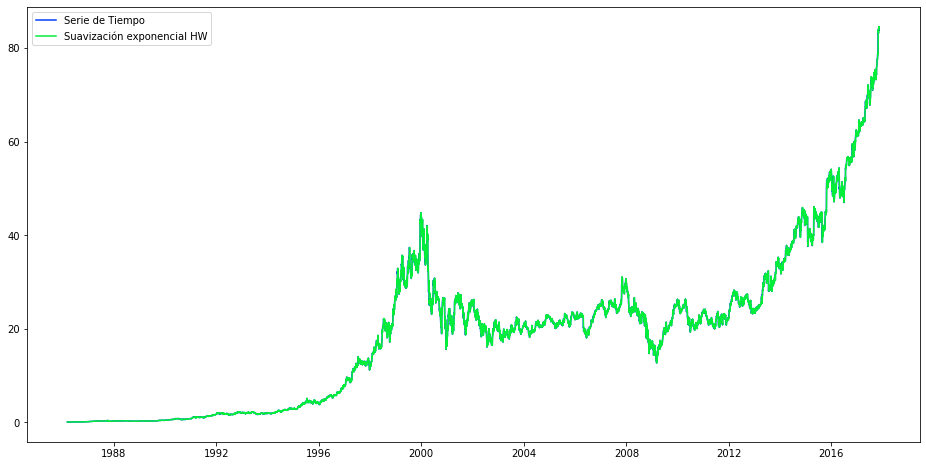

In [ ]:
plt.plot(datos['Close'],label='Serie de Tiempo')
plt.plot(datos['SEHW2'],label='Suavización exponencial HW')
plt.legend()
plt.show()

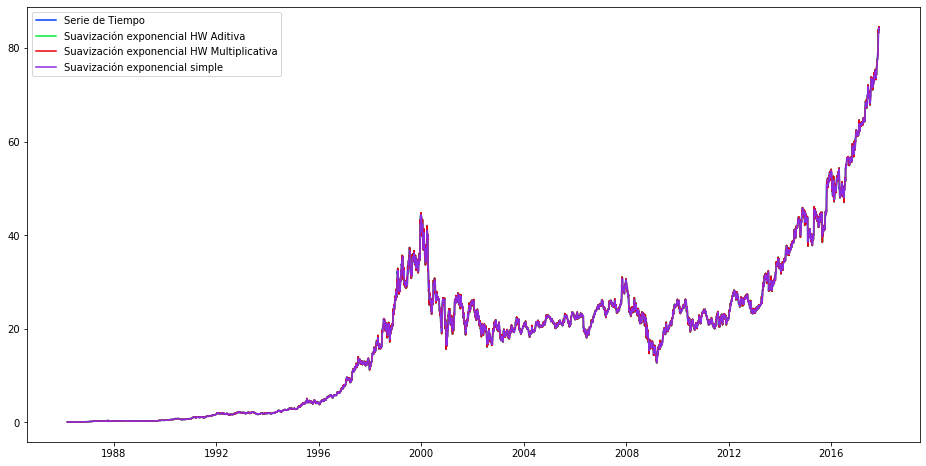

In [ ]:
plt.plot(datos['Close'],label='Serie de Tiempo')
plt.plot(datos['SEHW1'],label='Suavización exponencial HW Aditiva')
plt.plot(datos['SEHW2'],label='Suavización exponencial HW Multiplicativa')
plt.plot(datos['SES'],label='Suavización exponencial simple')
plt.legend()
plt.show()

In [ ]:
datosAjuste = datos.Close[1:7800]
datosValidacion = datos.Close[7800:]

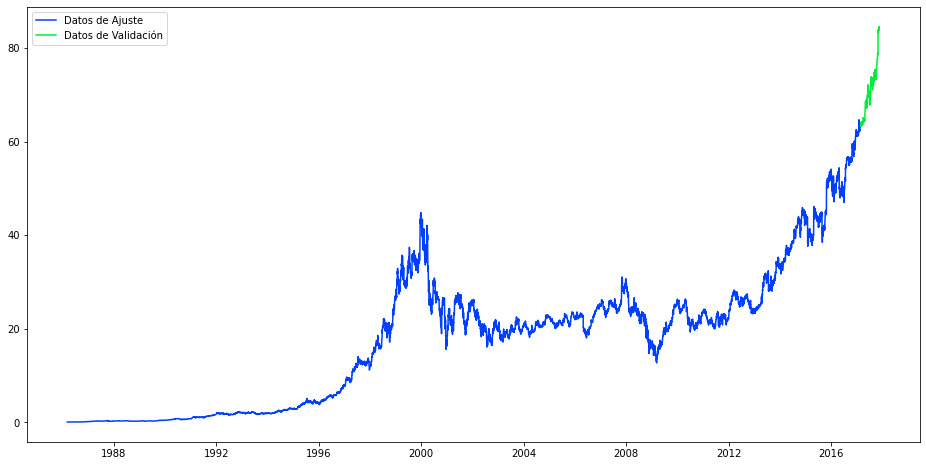

In [ ]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.legend()
plt.show()

In [ ]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul').fit()
predicciones= modeloAjustado.forecast(183)

In [ ]:
predicciones

7799    63.677881
7800    63.698911
7801    63.719948
7802    63.740992
7803    63.762043
          ...    
7977    67.532833
7978    67.555137
7979    67.577448
7980    67.599766
7981    67.622091
Length: 183, dtype: float64

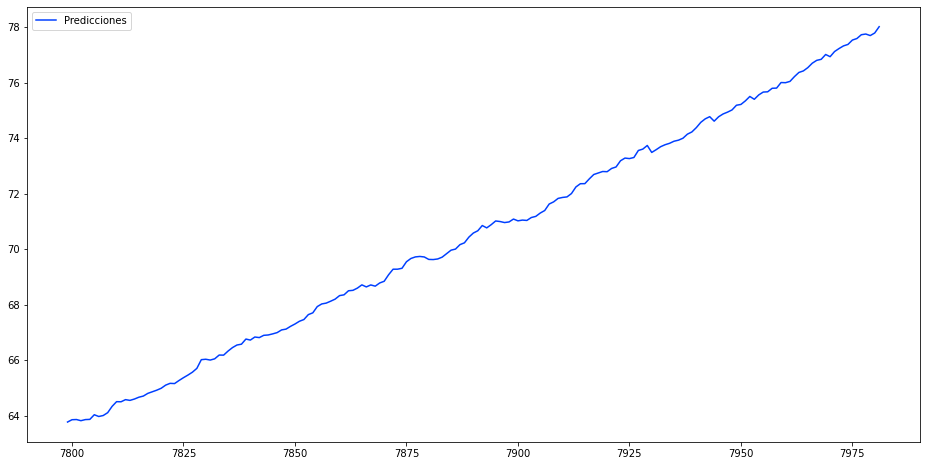

In [ ]:
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

In [ ]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add', seasonal_periods=365).fit()
predicciones= modeloAjustado.forecast(183)

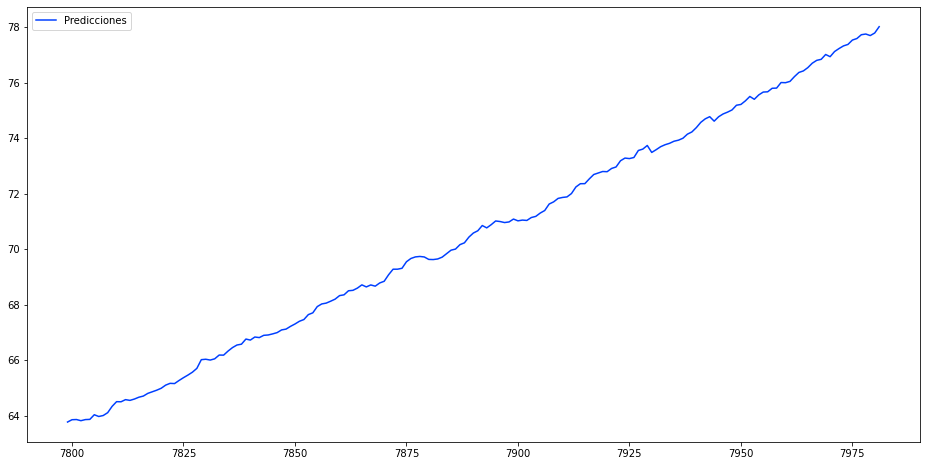

In [ ]:
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

##Auto ARIMA

In [ ]:
modeloAuto = pm.auto_arima(datos.Close, seasonal=True, stationary=False, start_q=1, start_p=1, d=1)

In [ ]:
modeloAuto.params()

intercept    0.010710
ar.L1       -0.020327
sigma2       0.185609
dtype: float64

In [ ]:
modeloAuto.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [ ]:
predAuto = modeloAuto.predict(56)

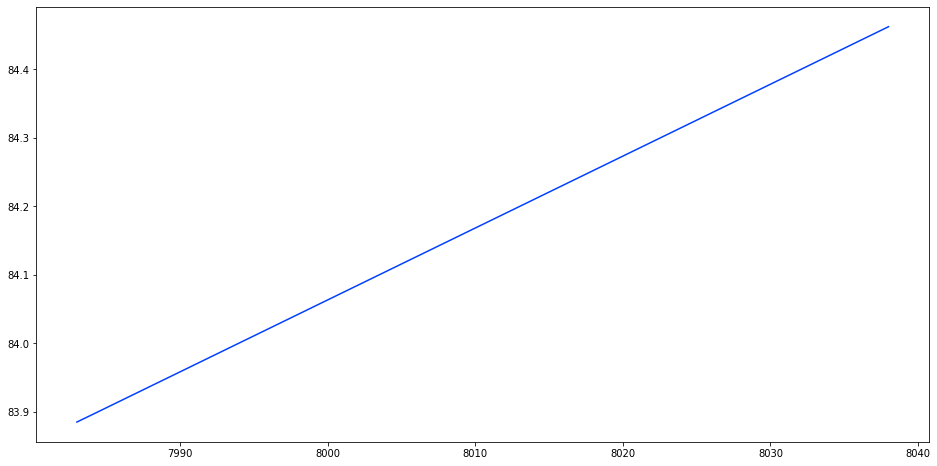

In [ ]:
plt.plot(predAuto)

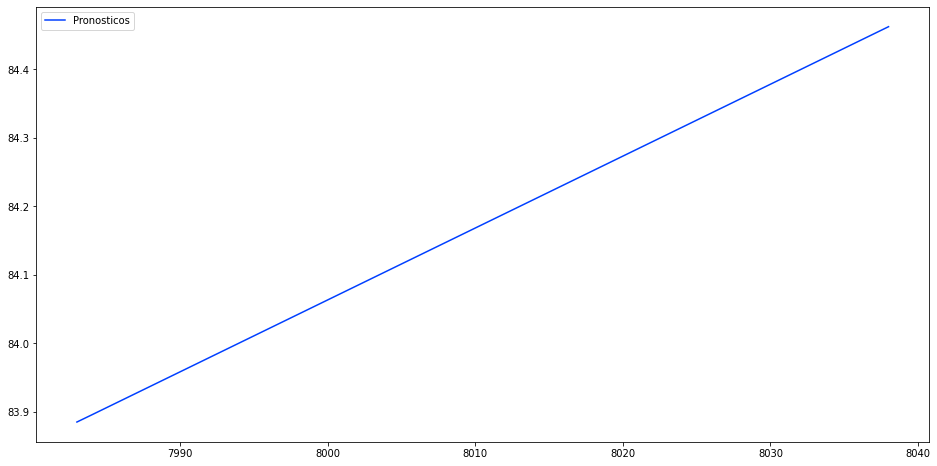

In [ ]:
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()

#Punto 6

##Exploración de datos

In [ ]:
###Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm

import warnings


In [ ]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('seaborn-bright')

In [ ]:
datos = pm.datasets.load_wineind(as_series=True)
print(datos.shape)
datos.head()

(176,)


Jan 1980    15136.0
Feb 1980    16733.0
Mar 1980    20016.0
Apr 1980    17708.0
May 1980    18019.0
dtype: float64

In [ ]:
datos.index = pd.to_datetime(datos.index, infer_datetime_format=True)
datos.head()

1980-01-01    15136.0
1980-02-01    16733.0
1980-03-01    20016.0
1980-04-01    17708.0
1980-05-01    18019.0
dtype: float64

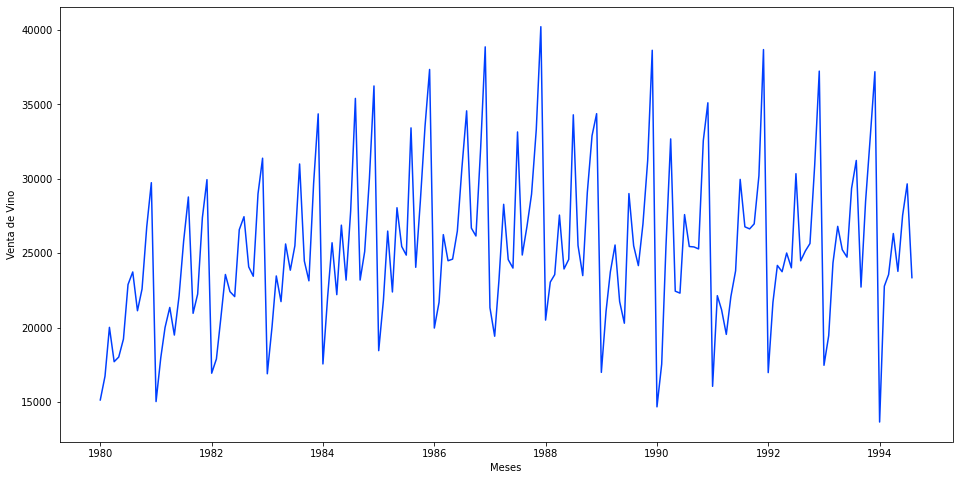

In [ ]:
#Gráfico de la serie
plt.xlabel('Meses')
plt.ylabel('Venta de Vino')
plt.plot(datos)
plt.show()

In [ ]:
#Identificar estacionariedad
mediaMovil = datos.rolling(window = 12).mean()
desviacionMediaMovil = datos.rolling(window = 12).std()

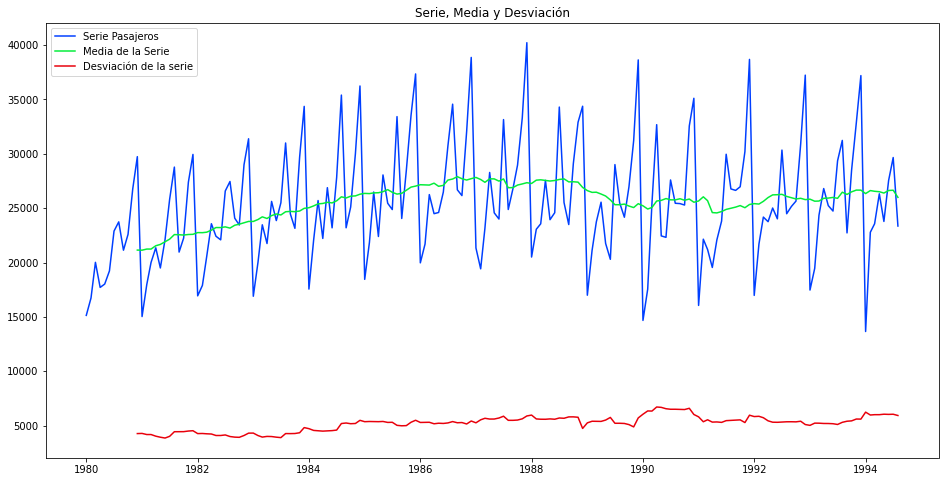

In [ ]:
plt.plot(datos, label='Serie Pasajeros')
plt.plot(mediaMovil, label='Media de la Serie')
plt.plot(desviacionMediaMovil, label='Desviación de la serie')
plt.legend(loc = 'best')
plt.title('Serie, Media y Desviación')
plt.show()

In [ ]:
print('Test de Dickey - Fuller:')
dftest = adfuller(datos.dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estadistico','Valor P','Retrasos Usados','Número de Observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores Críticos (%s)'%key]=value

print(dfoutput)

Test de Dickey - Fuller:
Estadistico                 -2.852468
Valor P                      0.051161
Retrasos Usados             11.000000
Número de Observaciones    164.000000
Valores Críticos (1%)       -3.470866
Valores Críticos (5%)       -2.879330
Valores Críticos (10%)      -2.576255
dtype: float64


##Transformación 

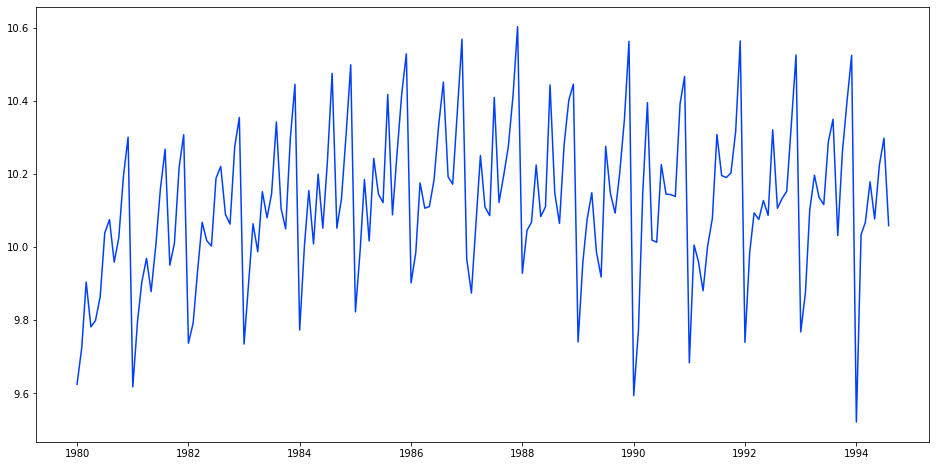

In [ ]:
#Aplicar Logaritmo
datosLog = np.log(datos)
plt.plot(datosLog)
plt.show()

In [ ]:
#Identificar estacionariedad
mediaMovilLog = datosLog.rolling(window = 12).mean()
desviacionMediaMovilLog = datosLog.rolling(window = 12).std()

In [ ]:
print('Test de Dickey - Fuller:')
dftest = adfuller(datosLog, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estadistico','Valor P','Retrasos Usados','Número de Observaciones'])
for key, value in dftest[4].items():
  dfoutput['Valores Críticos (%s)'%key]=value

print(dfoutput)

Test de Dickey - Fuller:
Estadistico                 -3.121612
Valor P                      0.024995
Retrasos Usados             11.000000
Número de Observaciones    164.000000
Valores Críticos (1%)       -3.470866
Valores Críticos (5%)       -2.879330
Valores Críticos (10%)      -2.576255
dtype: float64


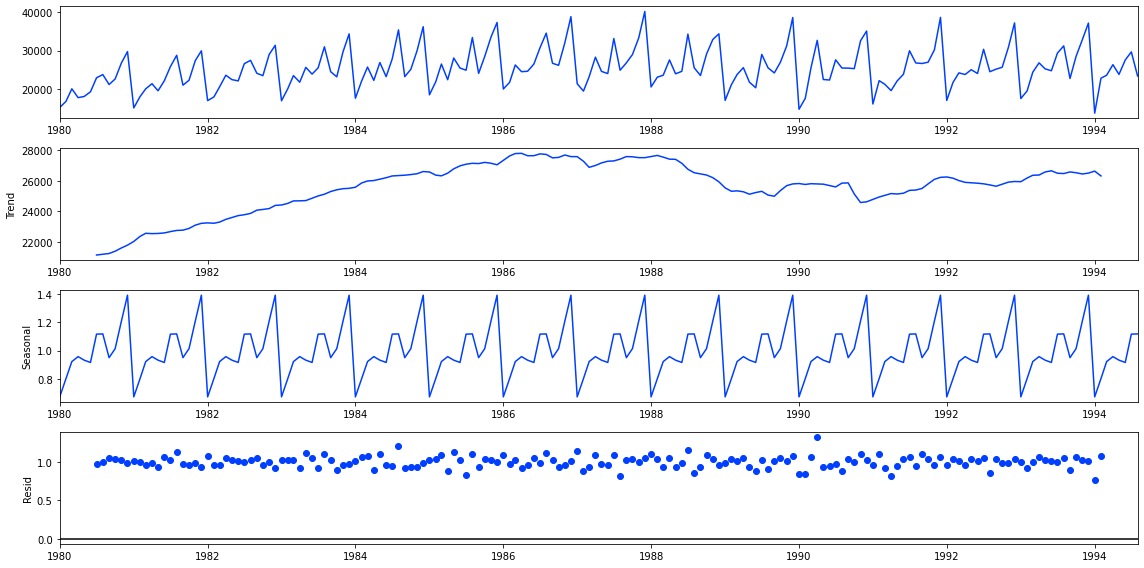

In [ ]:
#Descomposición de la serie de tiempo
descomposicion = seasonal_decompose(datos, model='multiplicative', period=12)
grafica = descomposicion.plot()

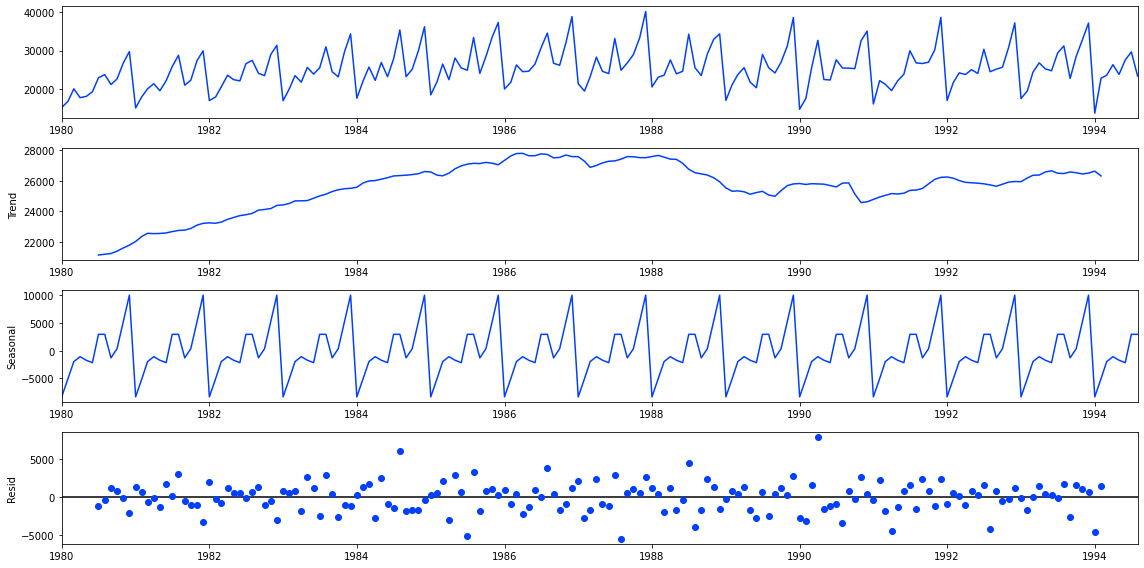

In [ ]:
#Descomposición de la serie de tiempo
descomposicionDif = seasonal_decompose(datos.dropna())
graficaDif = descomposicionDif.plot()

##Modelo Arima

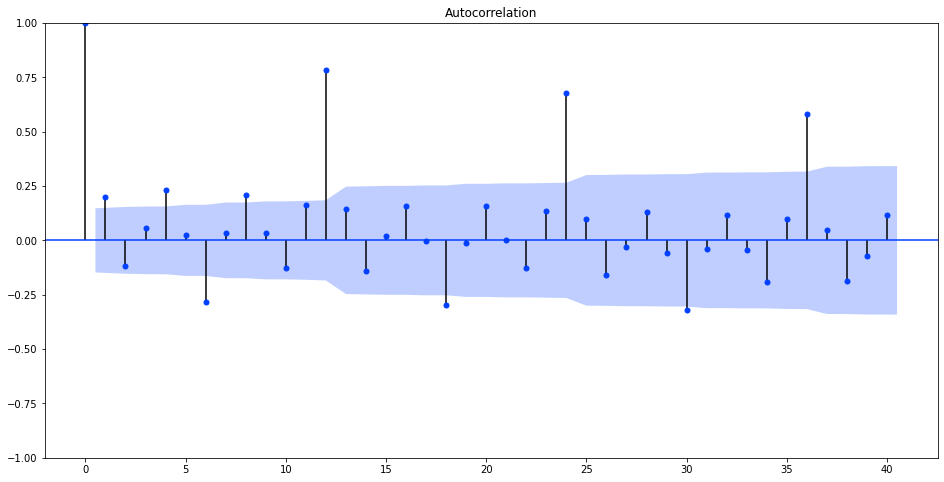

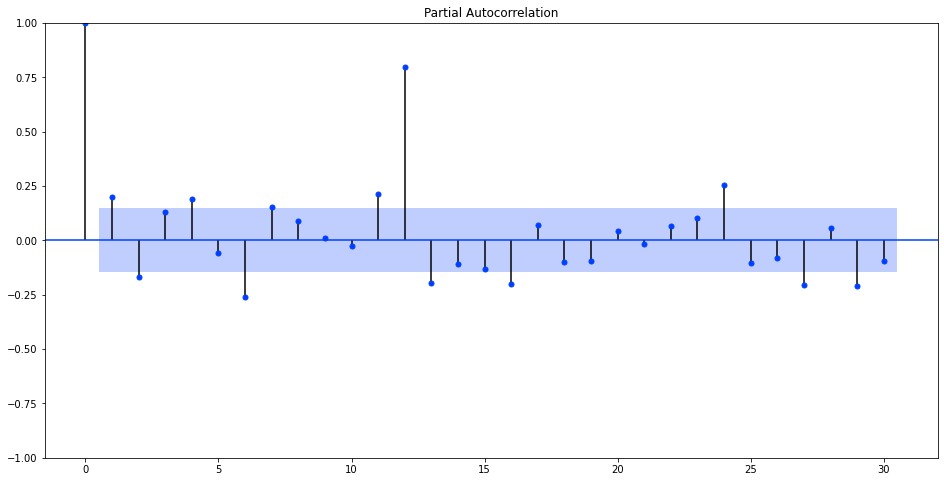

In [ ]:
#Modelo ARIMA
fig= sm.graphics.tsa.plot_acf(datosLog.dropna().values.squeeze(), lags=40)

fig= sm.graphics.tsa.plot_pacf(datosLog.dropna(), lags=30)

In [ ]:
#Primero Correlación parcial
#Segundo Transformaciones
#Tercero Autocorrelación
modelo = ARIMA(datosLog.dropna(), order=(2,1,1))
modeloAjustado = modelo.fit()

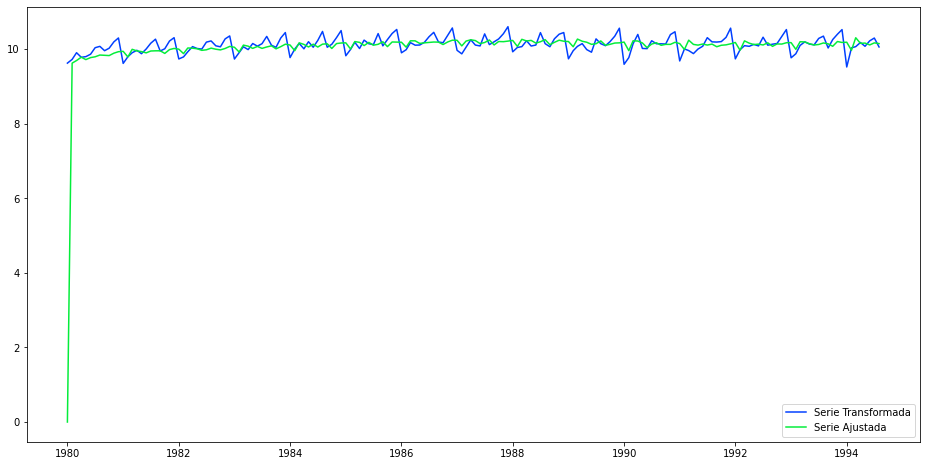

In [ ]:
plt.plot(datosLog.dropna(), label='Serie Transformada')
plt.plot(modeloAjustado.fittedvalues, label='Serie Ajustada')
plt.legend()
plt.show()

In [ ]:
modeloAjustado

In [ ]:
ajustes = pd.DataFrame(modeloAjustado.fittedvalues)
ajustes = ajustes.rename(columns = {0:'Sales'})
ajustes

Sales
1980-01-01   0.000000
1980-02-01   9.624831
1980-03-01   9.694890
1980-04-01   9.783307
1980-05-01   9.719621
...               ...
1994-04-01  10.155372
1994-05-01  10.162602
1994-06-01  10.113214
1994-07-01  10.168075
1994-08-01  10.149189

[176 rows x 1 columns]

In [ ]:
ajustes= ajustes.drop('Jan 1980',axis=0)

In [ ]:
predicciones = np.exp(ajustes)
predicciones = predicciones.dropna()
predicciones

Sales
1980-02-01  15135.996910
1980-03-01  16234.440199
1980-04-01  17735.199945
1980-05-01  16640.931482
1980-06-01  17559.621438
...                  ...
1994-04-01  25728.957491
1994-05-01  25915.650474
1994-06-01  24666.807847
1994-07-01  26057.874258
1994-08-01  25570.367021

[175 rows x 1 columns]

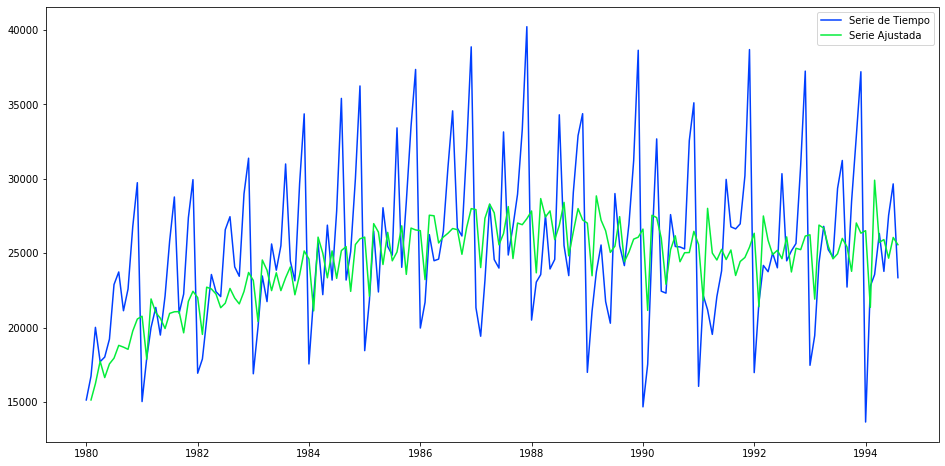

In [ ]:
plt.plot(datos, label='Serie de Tiempo')
plt.plot(predicciones, label='Serie Ajustada')
plt.legend()
plt.show()

In [ ]:
#Periodicidad 
m = 12
alfa = 1/(2*m)

##Suavización Exponencial

In [ ]:
datos = datos.to_frame(name='Sales')
datos

Sales
1980-01-01  15136.0
1980-02-01  16733.0
1980-03-01  20016.0
1980-04-01  17708.0
1980-05-01  18019.0
...             ...
1994-04-01  26323.0
1994-05-01  23779.0
1994-06-01  27549.0
1994-07-01  29660.0
1994-08-01  23356.0

[176 rows x 1 columns]

In [ ]:
datos['SES'] = SimpleExpSmoothing(datos['Sales']).fit(smoothing_level=alfa, optimized=False).fittedvalues
datos.head()

Sales           SES
1980-01-01  15136.0  15136.000000
1980-02-01  16733.0  15136.000000
1980-03-01  20016.0  15202.541667
1980-04-01  17708.0  15403.102431
1980-05-01  18019.0  15499.139829

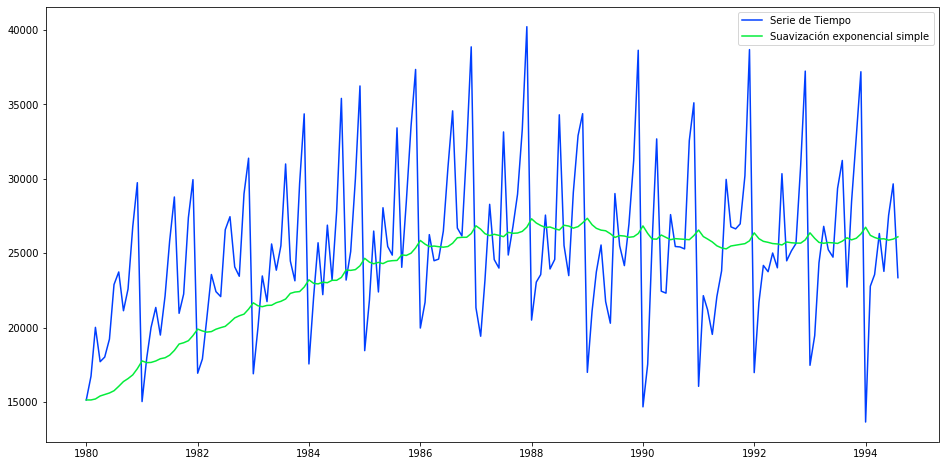

In [ ]:
plt.plot(datos['Sales'],label='Serie de Tiempo')
plt.plot(datos['SES'],label='Suavización exponencial simple')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW1'] = ExponentialSmoothing(datos['Sales'] ,trend = 'add').fit().fittedvalues
datos.head()

Sales           SES         SEHW1
1980-01-01  15136.0  15136.000000  16084.781818
1980-02-01  16733.0  15136.000000  16788.943727
1980-03-01  20016.0  15202.541667  17581.200230
1980-04-01  17708.0  15403.102431  18644.753391
1980-05-01  18019.0  15499.139829  19364.325299

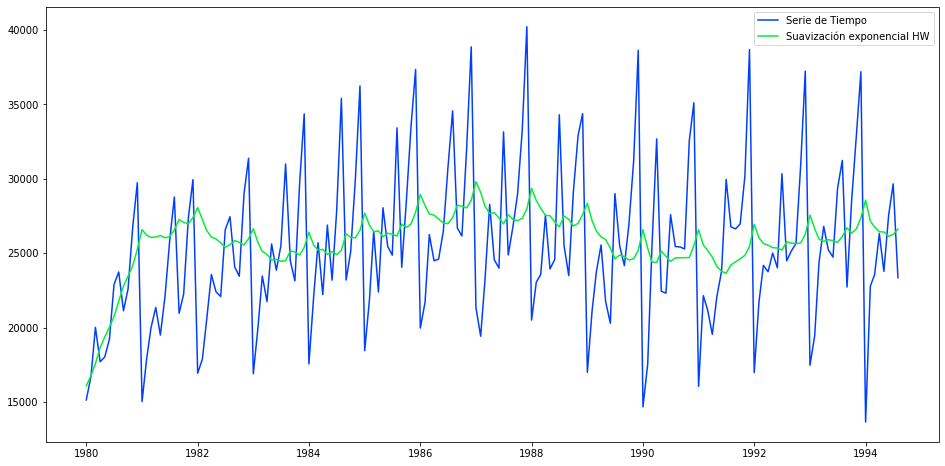

In [ ]:
plt.plot(datos['Sales'],label='Serie de Tiempo')
plt.plot(datos['SEHW1'],label='Suavización exponencial HW')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW2'] = ExponentialSmoothing(datos['Sales'] ,trend = 'mul').fit().fittedvalues
datos.head()

Sales           SES         SEHW1         SEHW2
1980-01-01  15136.0  15136.000000  16084.781818  16084.781818
1980-02-01  16733.0  15136.000000  16788.943727  16769.021069
1980-03-01  20016.0  15202.541667  17581.200230  17628.375238
1980-04-01  17708.0  15403.102431  18644.753391  18956.718467
1980-05-01  18019.0  15499.139829  19364.325299  19769.713006

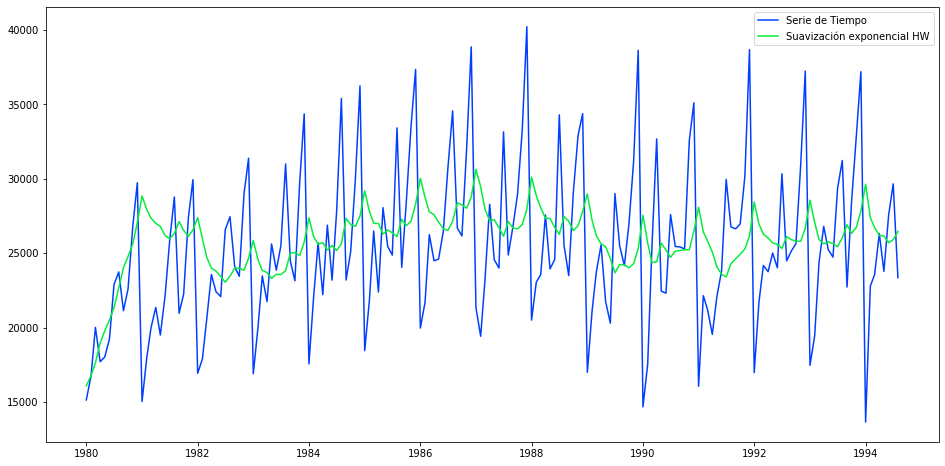

In [ ]:
plt.plot(datos['Sales'],label='Serie de Tiempo')
plt.plot(datos['SEHW2'],label='Suavización exponencial HW')
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Holt-Winters Aditiva
datos['SEHW3'] = ExponentialSmoothing(datos['Sales'] ,trend = 'mul', seasonal='add').fit().fittedvalues
datos.head()

Sales           SES         SEHW1         SEHW2         SEHW3
1980-01-01  15136.0  15136.000000  16084.781818  16084.781818  13642.034794
1980-02-01  16733.0  15136.000000  16788.943727  16769.021069  16560.271153
1980-03-01  20016.0  15202.541667  17581.200230  17628.375238  19455.168758
1980-04-01  17708.0  15403.102431  18644.753391  18956.718467  19336.162403
1980-05-01  18019.0  15499.139829  19364.325299  19769.713006  20582.318480

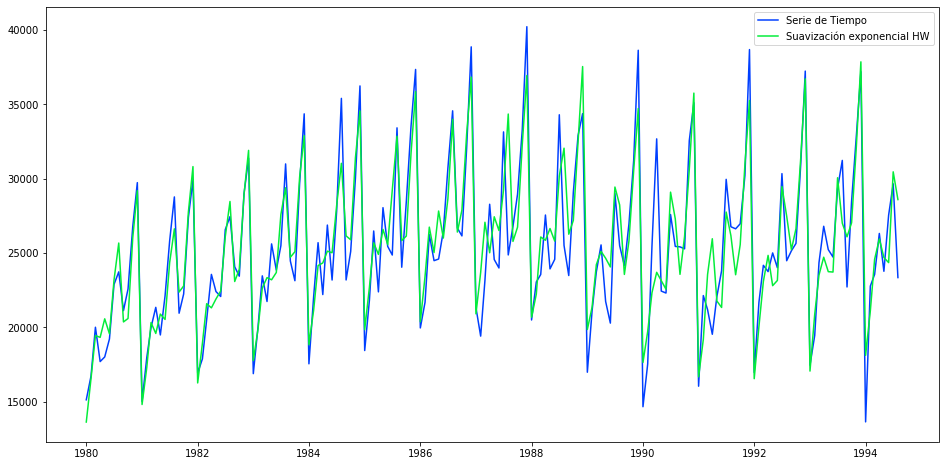

In [ ]:
plt.plot(datos['Sales'],label='Serie de Tiempo')
plt.plot(datos['SEHW3'],label='Suavización exponencial HW')
plt.legend()
plt.show()

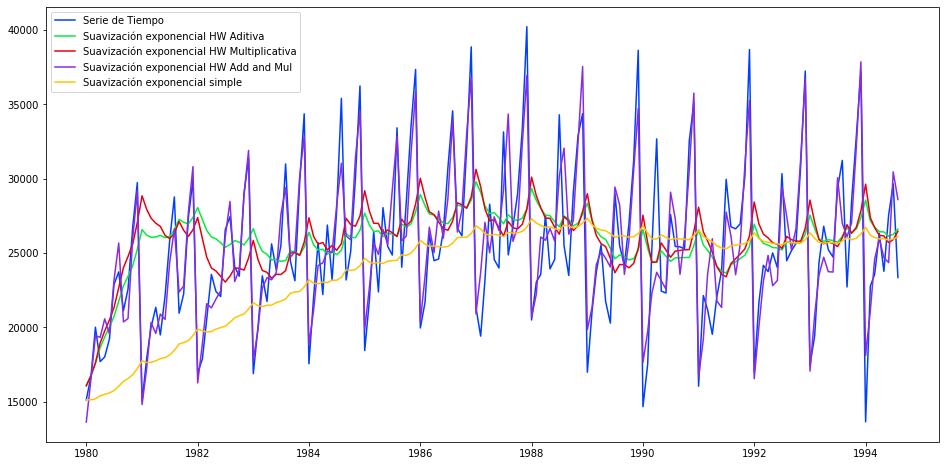

In [ ]:
plt.plot(datos['Sales'],label='Serie de Tiempo')
plt.plot(datos['SEHW1'],label='Suavización exponencial HW Aditiva')
plt.plot(datos['SEHW2'],label='Suavización exponencial HW Multiplicativa')
plt.plot(datos['SEHW3'],label='Suavización exponencial HW Add and Mul')
plt.plot(datos['SES'],label='Suavización exponencial simple')
plt.legend()
plt.show()

In [ ]:
datosAjuste = datos.Sales[1:120]
datosValidacion = datos.Sales[120:]

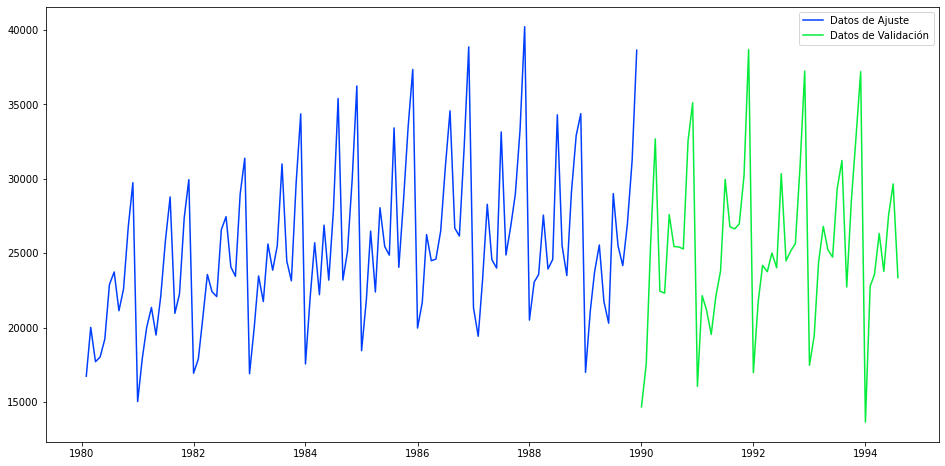

In [ ]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.legend()
plt.show()

In [ ]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add').fit()
predicciones= modeloAjustado.forecast(56)

In [ ]:
predicciones

1990-01-01    17298.644282
1990-02-01    20070.079722
1990-03-01    22481.991836
1990-04-01    24682.310856
1990-05-01    21696.953596
1990-06-01    21134.332079
1990-07-01    29456.399411
1990-08-01    25210.647084
1990-09-01    23286.341527
1990-10-01    26437.899266
1990-11-01    30705.919317
1990-12-01    34483.857297
1991-01-01    16578.257182
1991-02-01    19351.298801
1991-03-01    21764.813513
1991-04-01    23966.731558
1991-05-01    20982.969757
1991-06-01    20421.940143
1991-07-01    28745.595827
1991-08-01    24501.428311
1991-09-01    22578.704032
1991-10-01    25731.839524
1991-11-01    30001.433809
1991-12-01    33780.942514
1992-01-01    15876.909622
1992-02-01    18651.514969
1992-03-01    21066.589922
1992-04-01    23270.064730
1992-05-01    20287.856221
1992-06-01    19728.376436
1992-07-01    28053.578494
1992-08-01    23810.953903
1992-09-01    21889.769110
1992-10-01    25044.440654
1992-11-01    29315.567568
1992-12-01    33096.605484
1993-01-01    15194.098393
1

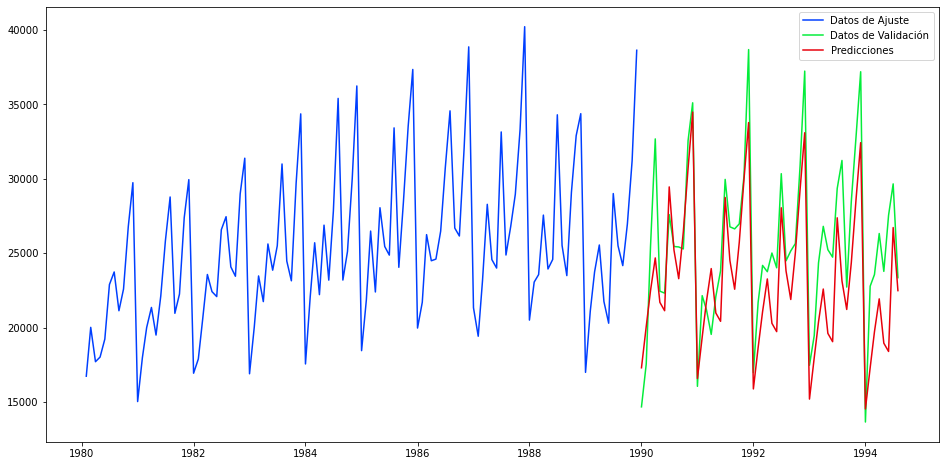

In [ ]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

In [ ]:
modeloAjustado = ExponentialSmoothing(datosAjuste, trend='mul', seasonal='add', seasonal_periods=12).fit()
predicciones= modeloAjustado.forecast(56)

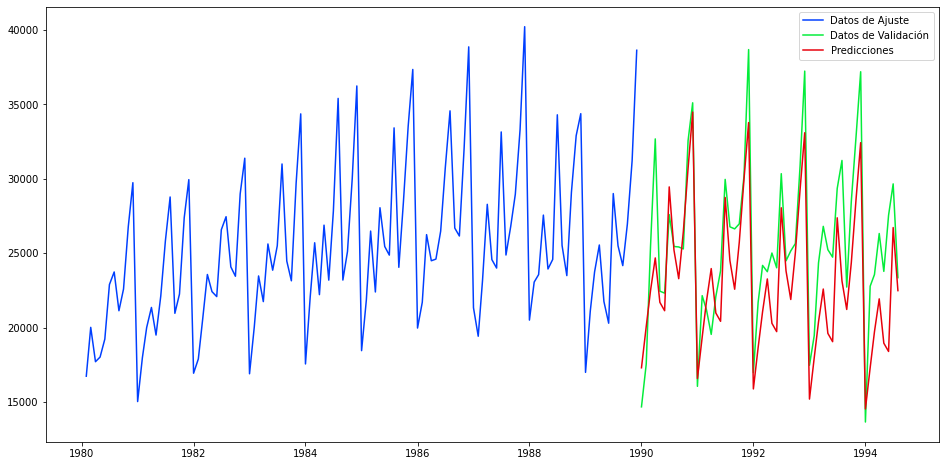

In [ ]:
plt.plot(datosAjuste, label='Datos de Ajuste')
plt.plot(datosValidacion, label='Datos de Validación')
plt.plot(predicciones, label='Predicciones')
plt.legend()
plt.show()

##Auto ARIMA

In [ ]:
modeloAuto = pm.auto_arima(datos.Sales, seasonal=True, stationary=False, start_q=1, start_p=1, d=1)

In [ ]:
modeloAuto.params()

ar.L1     1.419900e-01
ar.L2    -2.572153e-01
ma.L1    -9.074271e-01
sigma2    2.912377e+07
dtype: float64

In [ ]:
modeloAuto.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [ ]:
predAuto = modeloAuto.predict(56)

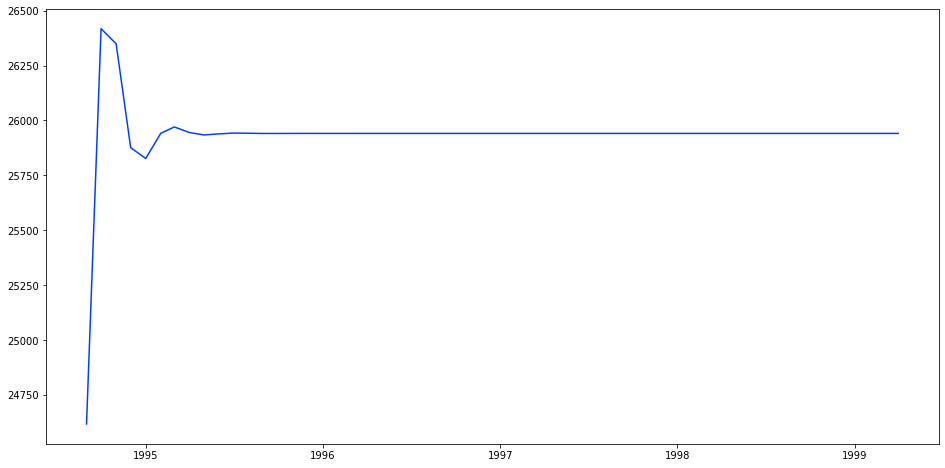

In [ ]:
plt.plot(predAuto)

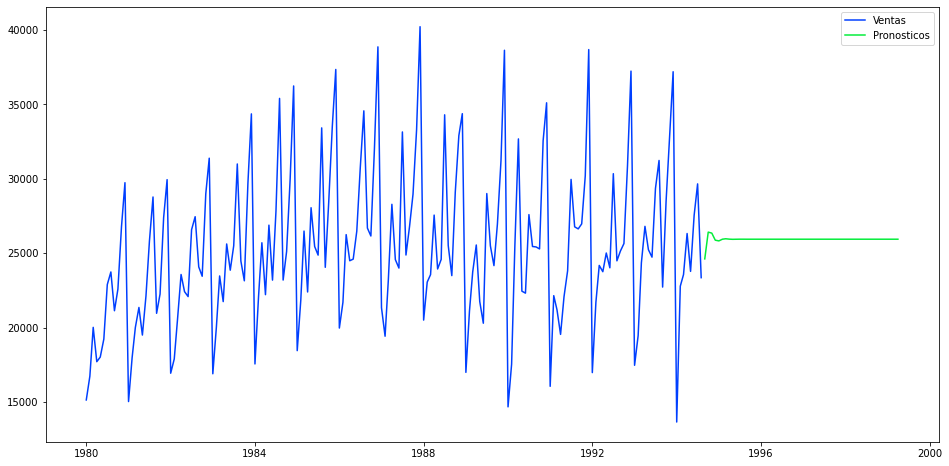

In [ ]:
plt.figure(figsize= (16,8))
plt.plot(datos.Sales, label='Ventas')
plt.plot(predAuto, label='Pronosticos')
plt.legend()
plt.show()